# Projet 5 : Catégorisez automatiquement des questions
Étudiant BOUTROIX Laurent parcours Ingénieur Machine Learning

## Un Énoncé :
Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Des Contraintes :
Mettre en œuvre une approche non supervisée.
Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

## Une Problématique :
Mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Hypothèse Générale :
Pouvons-nous mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question ?

## Hypothèses Secondaires :
Pouvons-nous mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation ?

Pouvons-nous déployer le code final pour le mettre à la dispostion de la communauté ?


## Partie 1 : Exploration des données.

### Installation des dépendances :

In [1]:
# conda install -c conda-forge nltk

In [2]:
# pip install beautifulsoup4

In [3]:
# pip install langdetect

In [4]:
# pip install pycodestyle

In [5]:
# pip install wordcloud

### Importation des dépendances :

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt, floor

from PIL import Image

import time
import datetime as dt
from datetime import date, timedelta

import re

import spacy

from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer

from wordcloud import WordCloud

from sklearn.preprocessing import KBinsDiscretizer

from langdetect import detect

In [7]:
start_dr1 = time.process_time()

### Définition des fonctions.

##### Définition d'une fonction `vue_globale_df()` qui décrit brièvement le contenu de chaque variable d'une base de données.

In [8]:
def vue_globale_df(df):
    print("Vue globale des valeurs par variables du dataframe :\n")
    dfshow = df.copy()
    for (columnName, columnData) in dfshow.iteritems():
        print("Colunm Name : ", columnName)
        print("Number of non null values of the column : ", columnData.count())
        print(
            "Number of distinct observations over the column : ", columnData.nunique()
        )
        print("List of all the values of the column : ", columnData.values)
        print("Counts of unique values of the column : ", columnData.value_counts())
        print("Unique values of the column : ", columnData.unique())
        print(
            "-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-"
        )

##### Définition d'une fonction `drop_row_var_is_null()` qui supprime tous les individus présentant une valeur `null` pour la variable indiquée.

In [9]:
def drop_row_var_is_null(df, name_var="name_of_variable"):
    index_row = df.index[df[name_var].isnull()]
    df.drop(index_row, 0, inplace=True)
    df = df.reset_index()
    df = df.drop(df.columns[[0]], axis=1)

##### Définition d'une fonction `drop_row_var_egal_it()` qui supprime tous les individus présentant une valeur égale à la valeur indiquée pour la variable indiquée.

In [10]:
def drop_row_var_egal_it(df, name_var="name_var", value=0):
    df.drop(df.loc[df[name_var] == value].index, inplace=True)
    df = df.reset_index()
    df = df.drop(df.columns[[0]], axis=1)

##### Définition d'une fonction `drop_row_var_sup_it()` qui supprime tous les individus présentant une valeur supérieure à la valeur indiquée pour la variable indiquée.

In [11]:
def drop_row_var_sup_it(df, name_var="name_var", value=0):
    df.drop(df.loc[df[name_var] > value].index, inplace=True)
    df = df.reset_index()
    df = df.drop(df.columns[[0]], axis=1)

##### Définition d'une fonction `drop_row_var_inf_it()` qui supprime tous les individus présentant une valeur inférieure à la valeur indiquée pour la variable indiquée.

In [12]:
def drop_row_var_inf_it(df, name_var="name_var", value=0):
    df.drop(df.loc[df[name_var] < value].index, inplace=True)
    df = df.reset_index()
    df = df.drop(df.columns[[0]], axis=1)

##### Définition d'une fonction `code_strip()`  qui nettoie le texte afin de ne conserver que les caractères alphabétiques et le symbole +.

In [13]:
def code_norm(text):
    text = text.strip(u"\n")
    text = re.sub("[^a-zA-Z+]", " ", text)
    text = text.lower()
    return text

##### Définition d'une fonction lower() qui met en miniscule les caractères alphabétiques.

In [14]:
def lower(text):
    text = text.lower()
    return text

##### Définition d'une fonction `tokenize_text()` qui tokenise les mots.

In [15]:
def tokenize_text(text):
    text = word_tokenize(text)
    return text

##### Définition d'une fonction `defin_lang()` qui défini la langue de chaque individus.

In [16]:
def defin_lang(x):
    try:
        return detect(x)
    except:
        pass

##### Définition d'une fonction `supp_stopwords()` qui supprime les stopwords du coprs du texte.

In [17]:
def supp_stopwords(text):
    return [w for w in text if not w in stop_words]

##### Définition d'une fonction `lemmatizeur()` qui lemmatize les mots.

In [18]:
def lemmatizeur(text):
    lemmatizer = WordNetLemmatizer()
    text1 = []
    for word in text:
        word_ = lemmatizer.lemmatize(word)
        text1.append(word_)
    return text1

##### Définition d'une fonction `word_pos_lemma()` qui lemmatize les mots et les filtre selon leur type.

In [19]:
def word_pos_lemma(text):
    text1 = nlp(text)
    #Filter on POS tags and StopWords  
    text_filtered = [word.lemma_ for word in text1 if (word.pos_ in keep_postags)]     
    return text_filtered

##### Définition d'une fonction `stemmizeur()` qui stemmize les mots.

In [20]:
def stemmizeur(text):
    ps = EnglishStemmer()
    text1 = []
    for word in text:
        word_ = ps.stem(word)
        text1.append(word_)
    return text1

##### Définition d'une fonction `multi_histo()` qui trace des histogrammes des variables quantitatives de la base de données.

In [21]:
def multi_histo(df, cols, nb_cols, larg, haut, colour="colour", title="title"):
    num_plots = len(cols)
    num_cols = nb_cols
    num_rows = ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(larg, haut))
    fig.suptitle(title, fontsize=32, x=0.5, y=0.95)

    for ind, col in enumerate(cols):
        i = floor(ind / num_cols)
        j = ind - i * num_cols

        if num_rows == 1:
            if num_cols == 1:
                sns.histplot(df[col], color=colour, ax=axs, bins=100, kde=True)
                ax = axs
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
            else:
                sns.histplot(df[col], color=colour, ax=axs[j], bins=100, kde=True)
                ax = axs[j]
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
        else:
            sns.histplot(df[col], color=colour, ax=axs[i, j], bins=100, kde=True)
            ax = axs[i, j]
            ax.set_xlabel(col, fontdict={"fontsize": 18})
            ax.set_ylabel("")

##### Définition d'une fonction `multi_box()` qui trace des boîtes à moustaches des variables quantitatives de la base de données.

In [22]:
def multi_box(df, cols, nb_cols, larg, haut, colour="colour", title="title"):
    num_plots = len(cols)
    num_cols = nb_cols
    num_rows = ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(larg, haut))
    fig.suptitle(title, fontsize=32, x=0.5, y=0.95)

    for ind, col in enumerate(cols):
        i = floor(ind / num_cols)
        j = ind - i * num_cols

        if num_rows == 1:
            if num_cols == 1:
                sns.boxplot(x=df[col], color=colour, ax=axs, showfliers=False)
                ax = axs
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
            else:
                sns.boxplot(x=df[col], color=colour, ax=axs[j], showfliers=False)
                ax = axs[j]
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
        else:
            sns.boxplot(x=df[col], color=colour, ax=axs[i, j], showfliers=False)
            ax = axs[i, j]
            ax.set_xlabel(col, fontdict={"fontsize": 18})
            ax.set_ylabel("")

##### Définition d'une fonction `outliers_analyse()` qui calcule la moyenne, la médiane, l'écart type, le Q1, le Q3, l'écart interquartile, la valeur minimale et la valeur maximale et qui affiche un histogramme, un KDE et un boxplot pour chacune des variables quantitatives d'une base de donnée correspondant au type renseigné. 

In [23]:
def outliers_analyse(df, typage="type_var"):
    df_type = df.dtypes
    df_type_list = df_type[df_type == typage]
    for i in df_type_list.index:
        print("Variable: ", i)
        parameters = {"xtick.labelsize": 18, "ytick.labelsize": 18}
        plt.rcParams.update(parameters)
        mo = df[i].mean()
        print("\nLa moyenne de", i, "est égale à:", mo)
        me = df[i].median()
        print("La médiane de", i, "est égale à:", me)
        me = df[i].std()
        print("Écart type de", i, "est égale à:", me)
        mini = df[i].min()
        Q1 = round(np.percentile(df[i], 25))
        print("Quartile Q1 de", i, "vaut : ", Q1)
        Q3 = round(np.percentile(df[i], 75))
        print("Quartile Q3 de", i, "vaut : ", Q3)
        print("L ecart interquartile vaut : ", Q3 - Q1)
        print("La valeur minimale de", i, "est égale à:", mini)
        maxi = df[i].max()
        print("La valeur maximale de", i, "est égale à:", maxi)
        print("\nHistogramme représentant les valeurs de la variable", i)
        df[i].plot.hist()
        plt.show()
        print("\nTracé du KDE avec noyaux gaussiens", i)
        df[i].plot.kde()
        plt.show()
        print("\nBoxplot représentant les valeurs de la variable", i)
        df.boxplot(column=i, showfliers=True, vert=False)
        plt.show()
        print("--" * 50)
        print("\n")

##### Définition d'une fonction `count_tag()` qui récupère les mots d'une colonne d'un dataframe et qui regroupe les valeurs entre-elles et les compte.

In [24]:
def count_tag(df, column, separator):
    list_words = []
    for word in df[column]:
        list_words.extend(word)
    list_tag = pd.DataFrame(list_words, columns=["tag"])
    list_tag = list_tag.groupby("tag").agg(
        tag_count=pd.NamedAgg(column="tag", aggfunc="count")
    )
    list_tag.sort_values("tag_count", ascending=False, inplace=True)
    return list_tag

##### Définition d'une fonction `list_word()` qui récupère les mots d'une colonne d'un dataframe et qui les dépose dans une seule et même liste :

In [25]:
def list_word(df, column, separator):
    list_words = []
    for word in df[column]:
        list_words.extend(word)
    return list_words

##### Définition d'une fonction `len_words()` qui trie les mots selon leurs longueurs ou leurs appartenances à une liste liste :

In [26]:
def len_words(text):
    return [w for w in text if len(w) > 2 or w in little_words]

### Importation des 12 bases de données :

Chacune de ses bases de données étant un échantillon représentant une fraction de la période allant du 31 juillet 2007 au 10 février 2020. Les 5 dernières bases de données représentent la période complète allant du 2 décembre 2021 au 2 janvier 2022.

#### Requêtes SQL utilisées  pour obtenir les 12 bases de données :

SELECT Id,CreationDate,Title,Body,Tags,ViewCount,AnswerCount,Score,FavoriteCount FROM posts WHERE Id BETWEEN i AND j AND ParentId IS NULL


#### Importation et affichage des informations essentielles des 12 bases de données : 

##### df2008 : période du  31/07/2008 au 10/12/2008.

In [27]:
df2008 = pd.read_csv("./QueryResults_2008_1.csv")
df2008

Id         CreationDate  \
0           4  2008-07-31 21:42:52   
1           6  2008-07-31 22:08:08   
2           9  2008-07-31 23:40:59   
3          11  2008-07-31 23:55:37   
4          13  2008-08-01 00:42:38   
...       ...                  ...   
49995  356004  2008-12-10 13:18:01   
49996  356010  2008-12-10 13:19:28   
49997  356025  2008-12-10 13:24:43   
49998  356035  2008-12-10 13:28:26   
49999  356039  2008-12-10 13:30:17   

                                                   Title  \
0            How to convert a Decimal to a Double in C#?   
1      Why did the width collapse in the percentage w...   
2      How do I calculate someone's age based on a Da...   
3                          Calculate relative time in C#   
4                            Determine a user's timezone   
...                                                  ...   
49995                           Singleton Factory method   
49996  Have ReSharper keep 'using System;' when optim...   
49997                           iPhone - Getting Started   
49998         Algorithm for detecting "clusters" of dots   
49999                            Element-in-List testing   

                                                    Body  \
0      <p>I want to use a <code>Track-Bar</code> to c...   
1      <p>I have an absolutely positioned <code>div</...   
2      <p>Given a <code>DateTime</code> representing ...   
3      <p>Given a specific <code>DateTime</code> valu...   
4      <p>Is there a standard way for a web server to...   
...                                                  ...   
49995  <p>Is it possible to have a singleton in a fac...   
49996  <p>I was wondering if there is some option to ...   
49997  <p>I have found the "Getting Started" document...   
49998  <p>I have a 2D area with "dots" distributed on...   
49999  <p>For a stylesheet I'm writing (actually for ...   

                                                    Tags  ViewCount  \
0      <c#><floating-point><type-conversion><double><...      62551   
1                       <html><css><internet-explorer-7>      22333   
2                                   <c#><.net><datetime>     716062   
3      <c#><datetime><time><datediff><relative-time-s...     186201   
4      <html><browser><timezone><user-agent><timezone...     242469   
...                                                  ...        ...   
49995                                             <java>      17261   
49996  <c#><visual-studio-2008><resharper><using-dire...       1551   
49997                                    <iphone><xcode>       1877   
49998     <algorithm><data-structures><image-processing>      20008   
49999                                             <xslt>       7773   

       AnswerCount  Score  FavoriteCount  
0               12    752           59.0  
1                7    312           13.0  
2               69   2081          484.0  
3               40   1598          552.0  
4               27    667          157.0  
...            ...    ...            ...  
49995            5      4            1.0  
49996            2     13            2.0  
49997            8      7            9.0  
49998           16     43           33.0  
49999            2      5            1.0  

[50000 rows x 9 columns]

In [28]:
print("Nb de valeurs manquantes par variables :\n", df2008.isna().sum(), "\n")
vue_globale_df(df2008)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title                0
Body                 0
Tags                 0
ViewCount            0
AnswerCount          0
Score                0
FavoriteCount    16728
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [     4      6      9 ... 356025 356035 356039]
Counts of unique values of the column :  4         1
259024    1
258889    1
258893    1
258897    1
         ..
145770    1
145771    1
145775    1
145783    1
356039    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [     4      6      9 ... 356025 356035 356039]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of the column :  50000
Number of distinct observat

##### df2008 : période du  04/01/2010 au 02/05/2010.

In [29]:
df2010 = pd.read_csv("./QueryResults_2010_1.csv")
df2010

Id         CreationDate  \
0      2000005  2010-01-04 14:54:07   
1      2000025  2010-01-04 14:56:59   
2      2000030  2010-01-04 14:57:41   
3      2000037  2010-01-04 14:58:53   
4      2000043  2010-01-04 15:00:33   
...        ...                  ...   
49995  2205012  2010-02-05 04:18:08   
49996  2205015  2010-02-05 04:18:46   
49997  2205017  2010-02-05 04:20:20   
49998  2205021  2010-02-05 04:21:52   
49999  2205025  2010-02-05 04:23:40   

                                                   Title  \
0                                 div shadow with jquery   
1      Is it possible to build dynamic LINQ queries t...   
2      TortoiseSVN: How do I export an entire file tr...   
3      Will Visual Studio 2003 and 2008 fail graceful...   
4      Does lock create a pile-up of threads? / Is th...   
...                                                  ...   
49995                           C++ Template Portability   
49996                    Java Concurrency: lock effiency   
49997  Inserting rows into a table with multiple fiel...   
49998  Can you make an embedded MP3 keep playing from...   
49999                            Can I do this with PHP?   

                                                    Body  \
0      <p>Is there any plugin for use a shadow effect...   
1      <p>Using <a href="http://en.wikipedia.org/wiki...   
2      <p>I have my project in Tortoise SVN repositor...   
3      <p>I use google as my primary reference so I d...   
4      <p>I have a program which receives data from u...   
...                                                  ...   
49995  <p>I am updating a code base that is 10 years ...   
49996  <p>My program has 100 threads.</p>\n\n<p>Every...   
49997  <p>I am storing price data events for financia...   
49998  <p>Is it possible to make an mp3, that is embe...   
49999  <p>Consider,</p>\n\n<pre><code>  &lt;html&gt;\...   

                                                    Tags  ViewCount  \
0                                       <jquery><shadow>      14352   
1                                   <linq><dynamic-linq>        538   
2                    <svn><version-control><tortoisesvn>       3110   
3      <visual-studio><visual-studio-2008><msdn><visu...        130   
4                                          <c#><locking>        314   
...                                                  ...        ...   
49995                                   <c++><templates>        452   
49996  <java><multithreading><concurrency><performanc...       1744   
49997                            <sql><sql-server><tsql>        262   
49998                                        <html><mp3>        406   
49999                                              <php>        233   

       AnswerCount  Score  FavoriteCount  
0                2      2            NaN  
1                2      1            NaN  
2                3      4            1.0  
3                2      1            NaN  
4                2      1            NaN  
...            ...    ...            ...  
49995            4      4            NaN  
49996            5      6            1.0  
49997            1      0            NaN  
49998            3      0            NaN  
49999            5      3            NaN  

[50000 rows x 9 columns]

In [30]:
print("Nb de valeurs manquantes par variables :\n", df2010.isna().sum(), "\n")
vue_globale_df(df2010)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title                0
Body                 0
Tags                 0
ViewCount            0
AnswerCount          0
Score                0
FavoriteCount    26705
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [2000005 2000025 2000030 ... 2205017 2205021 2205025]
Counts of unique values of the column :  2000005    1
2138313    1
2138238    1
2138240    1
2138241    1
          ..
2069449    1
2069450    1
2069463    1
2069465    1
2205025    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [2000005 2000025 2000030 ... 2205017 2205021 2205025]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of the column :  50000
Numb

##### df2012 : période du  03/04/2012 au 15/04/2012.

In [31]:
df2012 = pd.read_csv("./QueryResults_2012_1.csv")
df2012

Id         CreationDate  \
0      10000005  2012-04-03 19:25:46   
1      10000007  2012-04-03 19:26:05   
2      10000008  2012-04-03 19:26:09   
3      10000014  2012-04-03 19:26:28   
4      10000019  2012-04-03 19:26:50   
...         ...                  ...   
49995  10164555  2012-04-15 17:55:31   
49996  10164558  2012-04-15 17:56:00   
49997  10164563  2012-04-15 17:57:13   
49998  10164565  2012-04-15 17:57:18   
49999  10164575  2012-04-15 17:58:04   

                                                   Title  \
0                               PHP Sort array by field?   
1                   Arrays in PHP seems to drop elements   
2      RESTful servlet URLs - servlet-mapping in web.xml   
3      How to De-Authenticate a Windows Auth user wit...   
4      Are arrays in MongoDB documents always kept in...   
...                                                  ...   
49995                       HTML - Styling a Form Button   
49996                     Cannot cast class A to class B   
49997  Is it advisable to use USER_NAME as the object...   
49998  How do I call a another class from a class in ...   
49999  Communication between server-side Ruby process...   

                                                    Body  \
0      <blockquote>\n<p><strong>Possible Duplicate:</...   
1      <p>I am building an app with complex data whic...   
2      <p>I feel like this is a common problem but no...   
3      <p>If a user logged in to my site with windows...   
4      <p>I can find ample evidence that MongoDBs are...   
...                                                  ...   
49995  <p>I'm trying to style my submit button for my...   
49996  <p>What is the proper way to access the field ...   
49997  <p>I am new to MongoDB and design schema for t...   
49998  <p>I am trying to call another class that is i...   
49999  <p>Context</p>\n\n<ul>\n<li>I have an app that...   

                                                    Tags  ViewCount  \
0                                 <php><arrays><sorting>   103770.0   
1                                          <php><arrays>       69.0   
2        <java><rest><servlets><spring-mvc><url-pattern>     7820.0   
3          <php><windows><iis-7><windows-authentication>     3410.0   
4                                              <mongodb>      166.0   
...                                                  ...        ...   
49995            <javascript><html><css><button><styles>    16647.0   
49996                                        <java><oop>     4973.0   
49997                                          <mongodb>       68.0   
49998                                      <java><class>    41987.0   
49999  <javascript><ruby><ajax><asynchronous><backgro...      443.0   

       AnswerCount  Score  FavoriteCount  
0              1.0     50            8.0  
1              2.0      1            NaN  
2              1.0      2            NaN  
3              1.0      2            2.0  
4              1.0      1            NaN  
...            ...    ...            ...  
49995          7.0      5            NaN  
49996          4.0      3            1.0  
49997          1.0      0            NaN  
49998          3.0      1            2.0  
49999          4.0      1            NaN  

[50000 rows x 9 columns]

In [32]:
print("Nb de valeurs manquantes par variables :\n", df2012.isna().sum(), "\n")
vue_globale_df(df2012)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title              504
Body                97
Tags               506
ViewCount          506
AnswerCount        506
Score                0
FavoriteCount    34101
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [10000005 10000007 10000008 ... 10164563 10164565 10164575]
Counts of unique values of the column :  10000005    1
10109405    1
10109344    1
10109345    1
10109346    1
           ..
10054971    1
10054975    1
10054978    1
10054985    1
10164575    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [10000005 10000007 10000008 ... 10164563 10164565 10164575]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

Counts of unique values of the column :  1.0     22952
2.0     13196
3.0      6113
4.0      2697
0.0      2002
5.0      1233
6.0       562
7.0       280
8.0       155
9.0        89
10.0       56
12.0       32
11.0       30
14.0       18
13.0       17
15.0       11
16.0        8
17.0        7
18.0        6
22.0        4
21.0        4
19.0        3
26.0        3
28.0        3
29.0        2
25.0        2
35.0        2
20.0        2
37.0        1
33.0        1
31.0        1
60.0        1
23.0        1
Name: AnswerCount, dtype: int64
Unique values of the column :  [ 1.  2.  3.  0.  8. nan  6.  5.  4.  7. 26. 15. 12.  9. 16. 18. 14. 21.
 10. 11. 13. 29. 22. 25. 19. 37. 33. 31. 17. 35. 20. 28. 60. 23.]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  Score
Number of non null values of the column :  50000
Number of distinct observations over the column :  243
List of all the values of the column :  [50  1  2 ...  0  1  1]
Counts of unique values of the

##### df2014 : période du  24/02/2014 au 04/03/2014.

In [33]:
df2014 = pd.read_csv("./QueryResults_2014_1.csv")
df2014

Id         CreationDate  \
0      22000005  2014-02-24 22:01:27   
1      22000007  2014-02-24 22:01:44   
2      22000008  2014-02-24 22:01:48   
3      22000012  2014-02-24 22:01:57   
4      22000013  2014-02-24 22:02:02   
...         ...                  ...   
49995  22160817  2014-03-04 00:59:06   
49996  22160820  2014-03-04 00:59:13   
49997  22160826  2014-03-04 01:00:16   
49998  22160830  2014-03-04 01:00:44   
49999  22160840  2014-03-04 01:01:16   

                                                   Title  \
0             Built-in 64-bit hash function for QString?   
1      Fiddler core, targetSession.fullUrl is not mat...   
2              Excel text string shouldn't paste as date   
3      JSF HandleRenderException due to NullPointerEx...   
4      JQM, popup from link doesn't refresh select ra...   
...                                                  ...   
49995                                LEA in x86 assembly   
49996                        user upload to my S3 bucket   
49997                       Custom styling in Foundation   
49998                    How Can I Totally Reset Resque?   
49999              UnicodeEncodeError while parsing HTML   

                                                    Body  \
0      <p><code>qHash(const QString&amp;)</code> retu...   
1      <p>I am using Selenium webdriver, c# bindings ...   
2      <p>I want to copy a selection of cells from on...   
3      <p>I've been attempting to render database inf...   
4      <p>radio choice doesn't refresh?? Why doesn't ...   
...                                                  ...   
49995  <p>I am learning x86 assembly, and have some t...   
49996  <p>I would like for a user, <strong>without</s...   
49997  <p>Using Foundation 5</p>\n\n<pre><code>&lt;p ...   
49998  <p>My Rails app runs on Heroku using Resque ba...   
49999  <p>I'm trying to parse an HTML page with pytho...   

                                                    Tags  ViewCount  \
0                                 <c++><qt><hash><qhash>     4261.0   
1      <c#><selenium><selenium-webdriver><fiddler><fi...      414.0   
2                             <excel><csv><format><cell>       69.0   
3                              <jakarta-ee><el><jsf-2.2>    13411.0   
4                                <jquery><jquery-mobile>       90.0   
...                                                  ...        ...   
49995                                    <assembly><x86>     5734.0   
49996  <python><file-upload><amazon-web-services><ama...      139.0   
49997                                  <zurb-foundation>       99.0   
49998           <ruby-on-rails-3><heroku><redis><resque>      538.0   
49999  <python-3.x><unicode><utf-8><html-parsing><ascii>      101.0   

       AnswerCount  Score  FavoriteCount  
0              2.0      4            NaN  
1              1.0      0            0.0  
2              1.0      0            NaN  
3              2.0      2            NaN  
4              0.0      0            NaN  
...            ...    ...            ...  
49995          2.0      7            2.0  
49996          2.0      0            NaN  
49997          1.0      0            NaN  
49998          0.0      0            NaN  
49999          1.0      0            NaN  

[50000 rows x 9 columns]

In [34]:
print("Nb de valeurs manquantes par variables :\n", df2014.isna().sum(), "\n")
vue_globale_df(df2014)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title              366
Body                52
Tags               366
ViewCount          366
AnswerCount        366
Score                0
FavoriteCount    38611
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [22000005 22000007 22000008 ... 22160826 22160830 22160840]
Counts of unique values of the column :  22000005    1
22107313    1
22107231    1
22107234    1
22107235    1
           ..
22053989    1
22053993    1
22053996    1
22053998    1
22160840    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [22000005 22000007 22000008 ... 22160826 22160830 22160840]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

Counts of unique values of the column :  <javascript><jquery>                                   322
<html><css>                                            319
<android>                                              274
<php>                                                  273
<java>                                                 267
                                                      ... 
<javascript><html><css><twitter-bootstrap><firefox>      1
<c#><.net><asp.net-mvc-3><entity-framework>              1
<python><graph><igraph><networkx>                        1
<colors>                                                 1
<python-3.x><unicode><utf-8><html-parsing><ascii>        1
Name: Tags, Length: 34716, dtype: int64
Unique values of the column :  ['<c++><qt><hash><qhash>'
 '<c#><selenium><selenium-webdriver><fiddler><fiddlercore>'
 '<excel><csv><format><cell>' ...
 '<python><file-upload><amazon-web-services><amazon-s3>'
 '<ruby-on-rails-3><heroku><redis><resque>'
 '<python-3.x><uni

##### df2016 : période du  26/06/2016 au 01/07/2016.

In [35]:
df2016 = pd.read_csv("./QueryResults_2016_1.csv")
df2016

Id         CreationDate  \
0      38000001  2016-06-23 19:16:25   
1      38000006  2016-06-23 19:16:35   
2      38000009  2016-06-23 19:16:40   
3      38000012  2016-06-23 19:16:45   
4      38000013  2016-06-23 19:16:49   
...         ...                  ...   
49995  38154977  2016-07-01 23:25:33   
49996  38154981  2016-07-01 23:25:54   
49997  38154982  2016-07-01 23:26:02   
49998  38154983  2016-07-01 23:26:36   
49999  38154985  2016-07-01 23:26:44   

                                                   Title  \
0      Is there a thing such as custom boolean attrib...   
1             ColdFusion.Ajax.Submit cannot find form id   
2                 submit country by ISO code - html form   
3       Error in loading the results from plotGoogleMaps   
4      Using AnimatedVectorDrawables to make the Andr...   
...                                                  ...   
49995                    Why is "ALL" breaking my query?   
49996                   Dagger 2 Cross-Module Dependency   
49997                   SQL insert into.. where (python)   
49998  locals AND locals._locals (clone) sent from se...   
49999                           String to LPCWSTR in c++   

                                                    Body  \
0      <p>In HTML5 we can use custom <a href="http://...   
1      <p>This form is pretty straight forward and no...   
2      <p>So i would like to offer a list of all coun...   
3      <p>I am trying to run the following example on...   
4      <p>I'm trying to create a simple animation of ...   
...                                                  ...   
49995  <p>Here is the Error I am receiving.</p>\n\n<p...   
49996  <p>In my current project we have an <code>Appl...   
49997  <p>I have the following code:</p>\n\n<pre><cod...   
49998  <p>I've noticed I have a duplicate of my local...   
49999  <p>I'm trying to convert from string to LPCWST...   

                                                    Tags  ViewCount  \
0                          <html><custom-data-attribute>     2490.0   
1                                 <coldfusion><ajaxform>       48.0   
2                                          <html><forms>      259.0   
3                                    <r><plotgooglemaps>      371.0   
4      <android><android-animation><android-drawable>...      556.0   
...                                                  ...        ...   
49995                                       <mysql><sql>       37.0   
49996          <android><dependency-injection><dagger-2>     2498.0   
49997                     <python><mysql><sql><database>      622.0   
49998         <javascript><node.js><express><keystonejs>       41.0   
49999              <c++><string><visual-studio><lpcwstr>    14103.0   

       AnswerCount  Score  FavoriteCount  
0              3.0      3            1.0  
1              0.0      0            NaN  
2              1.0      0            NaN  
3              1.0      0            NaN  
4              1.0      0            NaN  
...            ...    ...            ...  
49995          3.0     -2            1.0  
49996          2.0      2            NaN  
49997          1.0      1            0.0  
49998          1.0      0            0.0  
49999          2.0      5            1.0  

[50000 rows x 9 columns]

In [36]:
print("Nb de valeurs manquantes par variables :\n", df2016.isna().sum(), "\n")
vue_globale_df(df2016)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title              224
Body                30
Tags               224
ViewCount          224
AnswerCount        224
Score                0
FavoriteCount    39535
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [38000001 38000006 38000009 ... 38154982 38154983 38154985]
Counts of unique values of the column :  38000001    1
38103225    1
38103151    1
38103152    1
38103158    1
           ..
38052157    1
38052158    1
38052163    1
38052164    1
38154985    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [38000001 38000006 38000009 ... 38154982 38154983 38154985]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

Number of distinct observations over the column :  35051
List of all the values of the column :  ['<html><custom-data-attribute>' '<coldfusion><ajaxform>' '<html><forms>'
 ... '<python><mysql><sql><database>'
 '<javascript><node.js><express><keystonejs>'
 '<c++><string><visual-studio><lpcwstr>']
Counts of unique values of the column :  <android>                                                               293
<javascript>                                                            285
<html><css>                                                             257
<python>                                                                240
<php>                                                                   231
                                                                       ... 
<authentication><oauth><oauth-2.0><akka>                                  1
<java><excel><charts><apache-poi><powerpoint>                             1
<php><laravel><laravel-5.2><dompdf>                   

##### df2018 : période du  29/01/2018 au 07/02/2018.

In [37]:
df2018 = pd.read_csv("./QueryResults_2018_1.csv")
df2018

Id         CreationDate  \
0      48500005  2018-01-29 11:17:18   
1      48500011  2018-01-29 11:17:41   
2      48500012  2018-01-29 11:17:42   
3      48500014  2018-01-29 11:17:47   
4      48500015  2018-01-29 11:17:50   
...         ...                  ...   
49995  48656040  2018-02-07 04:29:28   
49996  48656041  2018-02-07 04:29:37   
49997  48656044  2018-02-07 04:29:50   
49998  48656047  2018-02-07 04:30:02   
49999  48656050  2018-02-07 04:30:21   

                                                   Title  \
0         Can't convert a string to JSON using python 3?   
1                       OnButton Click Share Preferences   
2       Card view where each corner has different radius   
3                      access control via pre-signed url   
4      Dask Dataframe Distributed Process ID Access D...   
...                                                  ...   
49995  Why is my gradient descent algorithm not worki...   
49996      copy selected row cell entries to other sheet   
49997          Having issue with variable inside HTA sub   
49998                       PHP's str_replace in Python?   
49999  JavaScript: Unexpected outcome of character re...   

                                                    Body  \
0      <p>I have a response object of byte type into ...   
1      <p>Below is my Code :</p>\n\n<pre><code>    pu...   
2      <p>This is what i do to create a card view.</p...   
3      <p>My media storage is Openstack object storag...   
4      <p>I am running a set of pandas-like transform...   
...                                                  ...   
49995  <p>I am trying to mimic the gradient descent a...   
49996  <p>I'm trying to provide the capability to sel...   
49997  <p>I have a HTA that I want to run for four ho...   
49998  <p>Is there anything similar in Python like PH...   
49999  <p>My code is failing the test cases "should r...   

                                                    Tags  ViewCount  \
0                             <python><json><python-3.x>      116.0   
1      <android><sharedpreferences><android-sharedpre...       90.0   
2                                   <ios><iphone><swift>       71.0   
3      <amazon-s3><storage><openstack><openstack-swif...      325.0   
4                       <python><dask><dask-distributed>      425.0   
...                                                  ...        ...   
49995  <python><machine-learning><linear-regression><...     1446.0   
49996                                       <vba><excel>       36.0   
49997              <variables><vbscript><procedure><hta>      164.0   
49998                                      <php><python>      304.0   
49999              <javascript><unit-testing><debugging>       47.0   

       AnswerCount  Score  FavoriteCount  
0              0.0      2            NaN  
1              2.0      1            NaN  
2              0.0      0            NaN  
3              0.0      1            NaN  
4              1.0      2            NaN  
...            ...    ...            ...  
49995          1.0      2            1.0  
49996          1.0      0            NaN  
49997          1.0      0            NaN  
49998          2.0      0            NaN  
49999          0.0      0            NaN  

[50000 rows x 9 columns]

In [38]:
print("Nb de valeurs manquantes par variables :\n", df2018.isna().sum(), "\n")
vue_globale_df(df2018)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title              139
Body                48
Tags               142
ViewCount          142
AnswerCount        142
Score                0
FavoriteCount    40016
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [48500005 48500011 48500012 ... 48656044 48656047 48656050]
Counts of unique values of the column :  48500005    1
48604265    1
48604207    1
48604209    1
48604210    1
           ..
48551814    1
48551816    1
48551822    1
48551823    1
48656050    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [48500005 48500011 48500012 ... 48656044 48656047 48656050]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

##### df2020 : période du  31/01/2020 au 10/02/2020.

In [39]:
df2020 = pd.read_csv("./QueryResults_2020_1.csv")
df2020

Id         CreationDate  \
0      60000000  2020-01-31 08:01:48   
1      60000003  2020-01-31 08:02:00   
2      60000006  2020-01-31 08:02:13   
3      60000011  2020-01-31 08:02:32   
4      60000015  2020-01-31 08:03:06   
...         ...                  ...   
49995  60154868  2020-02-10 16:51:13   
49996  60154879  2020-02-10 16:51:46   
49997  60154880  2020-02-10 16:51:46   
49998  60154886  2020-02-10 16:52:06   
49999  60154887  2020-02-10 16:52:08   

                                                   Title  \
0         How to build html from template in javaScript?   
1                           Image Not Shown on Html Page   
2            react native ignores android navigation bar   
3                angular-6-datatable multiselection rows   
4      Laravel - How do create Hierarchical dropdownl...   
...                                                  ...   
49995  C: How to print fahrenheit to celsius table in...   
49996  The await expression can only be used in an as...   
49997                Force Graph/Screen on Allow Add New   
49998  Selecting a gallery by data-id and putting chi...   
49999  How can I delete duplicates in two different c...   

                                                    Body  \
0      <p>I have template, and i need to build html. ...   
1      <p><img src="https://i.stack.imgur.com/N29kK.p...   
2      <p>There is such a problem, the react native a...   
3      <p>I am using angular-6-datatable in my angula...   
4      <p>I am Developing a Web Application with <cod...   
...                                                  ...   
49995  <p>I'm writing a function in C to print a tabl...   
49996  <p>I am trying to load some data from Firestor...   
49997  <p>I am looking to customize the allow add new...   
49998  <p>I have a couple of .gallery div's in my htm...   
49999  <p>I have two csv files and both have a common...   

                                                    Tags  ViewCount  \
0                                           <javascript>      164.0   
1                                           <java><html>       39.0   
2                  <reactjs><react-native><mobile><expo>       42.0   
3                <angular><angular6><angular-datatables>      741.0   
4                                         <php><laravel>       64.0   
...                                                  ...        ...   
49995                                                <c>      184.0   
49996  <asynchronous><flutter><dart><google-cloud-fir...     4956.0   
49997                                        <acumatica>       46.0   
49998              <javascript><jquery><arrays><foreach>       37.0   
49999                              <python><pandas><csv>       31.0   

       AnswerCount  Score  FavoriteCount  
0              2.0      2            1.0  
1              0.0      0            0.0  
2              0.0      0            NaN  
3              1.0      0            NaN  
4              1.0      0            NaN  
...            ...    ...            ...  
49995          2.0      0            0.0  
49996          2.0      5            NaN  
49997          1.0      0            NaN  
49998          2.0      0            NaN  
49999          1.0      0            NaN  

[50000 rows x 9 columns]

In [40]:
print("Nb de valeurs manquantes par variables :\n", df2020.isna().sum(), "\n")
vue_globale_df(df2020)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title              178
Body                45
Tags               178
ViewCount          178
AnswerCount        178
Score                0
FavoriteCount    43138
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [60000000 60000003 60000006 ... 60154880 60154886 60154887]
Counts of unique values of the column :  60000000    1
60103225    1
60103158    1
60103162    1
60103167    1
           ..
60052098    1
60052102    1
60052103    1
60052107    1
60154887    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [60000000 60000003 60000006 ... 60154880 60154886 60154887]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

Counts of unique values of the column :  <python>                                               350
<javascript>                                           309
<r>                                                    262
<python><pandas>                                       261
<excel><vba>                                           248
                                                      ... 
<python><audio><mp3><wav><pydub>                         1
<c#><asp.net><list><linq>                                1
<c#><sqlite><sqlite-net-extensions><sqlite-net-pcl>      1
<reactjs><react-router><react-router-v4>                 1
<javascript><jquery><arrays><foreach>                    1
Name: Tags, Length: 35207, dtype: int64
Unique values of the column :  ['<javascript>' '<java><html>' '<reactjs><react-native><mobile><expo>' ...
 '<python><jinja2>'
 '<asynchronous><flutter><dart><google-cloud-firestore>'
 '<javascript><jquery><arrays><foreach>']
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

##### df2022_1 : période du  10/12/2021 au 20/12/2021.

In [41]:
df2022_1 = pd.read_csv("./QueryResults_2022_1.csv")
df2022_1

Id         CreationDate  \
0      70300000  2021-12-10 05:09:38   
1      70300001  2021-12-10 05:09:50   
2      70300004  2021-12-10 05:10:26   
3      70300007  2021-12-10 05:10:46   
4      70300011  2021-12-10 05:11:00   
...         ...                  ...   
49995  70428809  2021-12-20 22:40:10   
49996  70428812  2021-12-20 22:40:29   
49997  70428818  2021-12-20 22:41:28   
49998  70428821  2021-12-20 22:42:00   
49999  70428824  2021-12-20 22:42:16   

                                                   Title  \
0           Minimization from histogram PDF with iminuit   
1      SQL Query to display the repeated value in col...   
2             Svelte can't find .ScrollTop of a variable   
3                        Callback and curly braces in C?   
4      problem when open with live server (visual stu...   
...                                                  ...   
49995  Can I add more than one variable to an existin...   
49996  How to assign a custom SQL query which returns...   
49997                     How to install and use po2json   
49998                         Can't get MongoDB to Start   
49999  the problem with leaflet and leaflet draw vue ...   

                                                    Body  \
0      <p>I am trying to use iminuit for an UnbinnedN...   
1      <p>I have a table like follows -</p>\n<div cla...   
2      <p>Hello I have an element which is being refe...   
3      <p>I’m trying to port a script written in C (i...   
4      <p>I am newbie with visual studio code and mee...   
...                                                  ...   
49995  <p>I have a starter pipeline with one task whi...   
49996  <p>For example, suppose I have three models: <...   
49997  <p>I want convert some wordpress <code>.po</co...   
49998  <p>I've tried this on CentOS 7 and 8 and I'm g...   
49999  <pre><code>mounted() {\n this.initMap();\n},\n...   

                                                    Tags  ViewCount  \
0          <python><numpy><scipy><minimization><iminuit>       21.0   
1                                          <sql><oracle>       35.0   
2                             <javascript><html><svelte>       39.0   
3                            <c><callback><curly-braces>       42.0   
4                             <html><visual-studio-code>       46.0   
...                                                  ...        ...   
49995  <bash><azure-devops><yaml><azure-pipelines><az...       44.0   
49996                               <python><sqlalchemy>       17.0   
49997                              <json><wordpress><po>       32.0   
49998                                 <mongodb><pritunl>       52.0   
49999        <javascript><vue.js><leaflet><leaflet-draw>       54.0   

       AnswerCount  Score  FavoriteCount  
0              0.0      0            NaN  
1              1.0      0            NaN  
2              1.0      0            NaN  
3              1.0     -1            NaN  
4              1.0      0            NaN  
...            ...    ...            ...  
49995          1.0      0            NaN  
49996          1.0      0            NaN  
49997          1.0      0            NaN  
49998          0.0      0            0.0  
49999          1.0      1            NaN  

[50000 rows x 9 columns]

In [42]:
print("Nb de valeurs manquantes par variables :\n", df2022_1.isna().sum(), "\n")
vue_globale_df(df2022_1)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title               78
Body                42
Tags                78
ViewCount           78
AnswerCount         78
Score                0
FavoriteCount    47076
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [70300000 70300001 70300004 ... 70428818 70428821 70428824]
Counts of unique values of the column :  70300000    1
70387383    1
70387328    1
70387330    1
70387332    1
           ..
70343939    1
70343941    1
70343944    1
70343948    1
70428824    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [70300000 70300001 70300004 ... 70428818 70428821 70428824]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

Unique values of the column :  ['<p>I am trying to use iminuit for an UnbinnedNLL using a PDF made from a histogram (for ROOT-speaking people, I am trying to do something equivalent to RooHistPDF). So far, I came up with this:</p>\n<pre class="lang-py prettyprint-override"><code>import numpy as np\nimport scipy.stats\n\nfrom iminuit import cost, Minuit\n\n# ... part of code where I load dq_data, dx_data, dq, dx\n\nn_bins = 50\nxrange = (0,20)\n\ndef cdf(x, gain):\n    hist = np.histogram(dq_data/dx_data/gain, range=xrange,bins=n_bins)\n    return scipy.stats.rv_histogram(hist).cdf(x)\n\nn, xe = np.histogram(dq/dx/4, bins=n_bins, range=x_range)\nc = cost.BinnedNLL(n, xe, cdf)\nm = Minuit(c, gain=4.3)\nm.limits[\'gain\'] = (3, 5)\nm.migrad()\n</code></pre>\n<p>However, I am getting abysmal results. Depending on the starting value I get <code>INVALID Minimum</code> and <code>ABOVE EDM threshold (goal x 10)</code> or values very close to the starting number. However, it\'s not hard to conv

##### df2022_2 : période du  20/12/2021 au 02/01/2022.

In [43]:
df2022_2 = pd.read_csv("./QueryResults_2022_2.csv")
df2022_2

Id         CreationDate  \
0      70428827  2021-12-20 22:42:28   
1      70428831  2021-12-20 22:42:49   
2      70428832  2021-12-20 22:43:10   
3      70428835  2021-12-20 22:43:25   
4      70428837  2021-12-20 22:43:32   
...         ...                  ...   
49995  70553741  2022-01-02 05:10:38   
49996  70553742  2022-01-02 05:10:45   
49997  70553743  2022-01-02 05:11:28   
49998  70553748  2022-01-02 05:12:09   
49999  70553755  2022-01-02 05:14:42   

                                                   Title  \
0      Is there a limit on the number of EBS Snapshot...   
1      How to get Stripe Elements to dynamically chan...   
2        How to chain like element with PHP DOMDocument?   
3                 How Do I Conditionally Filter a store?   
4      tensorflow @python3.10 tried many times but no...   
...                                                  ...   
49995               Jinja if else inside a html span tag   
49996  Preventing excessive rerendering when using ma...   
49997         X-axis not in order when using sns.relplot   
49998  #1235 - This version of MySQL doesn't yet supp...   
49999  Can't connect database container with server c...   

                                                    Body  \
0      <p>Recently, AWS started offering archival of ...   
1      <p>I am using stripe elements and dynamically ...   
2      <p>I am seeking to construct a HTML table usin...   
3      <p>I am fairly new to ExtJS and I am having tr...   
4      <p>i have installed 3.10 version of python and...   
...                                                  ...   
49995  <p>So I'm making a stock dashboard, from the a...   
49996  <p>I have an application that uses a mapbox ma...   
49997  <p>I made a line graph using sns relplot but i...   
49998  <p>I wanted to create an event to do something...   
49999  <p>I am creating a POD file with multiple cont...   

                                                    Tags  ViewCount  \
0          <amazon-web-services><amazon-ebs><aws-backup>       29.0   
1               <css><reactjs><next.js><stripe-payments>       40.0   
2                          <php><html><dom><domdocument>       31.0   
3                                                <extjs>       31.0   
4                                           <tensorflow>      101.0   
...                                                  ...        ...   
49995                  <javascript><html><flask><jinja2>       19.0   
49996  <javascript><reactjs><react-hooks><mapbox><vie...       34.0   
49997                      <python><matplotlib><seaborn>       46.0   
49998                                 <mysql><sql><wamp>       22.0   
49999                               <kubernetes><podman>       81.0   

       AnswerCount  Score  FavoriteCount  
0              1.0      0            NaN  
1              1.0      0            NaN  
2              1.0      0            NaN  
3              1.0      0            NaN  
4              1.0      1            NaN  
...            ...    ...            ...  
49995          0.0     -3            NaN  
49996          1.0      2            NaN  
49997          2.0      0            NaN  
49998          1.0     -1            NaN  
49999          2.0      1            NaN  

[50000 rows x 9 columns]

In [44]:
print("Nb de valeurs manquantes par variables :\n", df2022_2.isna().sum(), "\n")
vue_globale_df(df2022_2)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title               68
Body                34
Tags                68
ViewCount           68
AnswerCount         68
Score                0
FavoriteCount    47124
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [70428827 70428831 70428832 ... 70553743 70553748 70553755]
Counts of unique values of the column :  70428827    1
70511373    1
70511326    1
70511327    1
70511328    1
           ..
70469476    1
70469478    1
70469480    1
70469487    1
70553755    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [70428827 70428831 70428832 ... 70553743 70553748 70553755]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

Number of distinct observations over the column :  35843
List of all the values of the column :  ['<amazon-web-services><amazon-ebs><aws-backup>'
 '<css><reactjs><next.js><stripe-payments>'
 '<php><html><dom><domdocument>' ... '<python><matplotlib><seaborn>'
 '<mysql><sql><wamp>' '<kubernetes><podman>']
Counts of unique values of the column :  <python>                                                             529
<javascript>                                                         316
<python><pandas>                                                     197
<javascript><reactjs>                                                197
<html><css>                                                          190
                                                                    ... 
<android><retrofit><retrofit2>                                         1
<android><kotlin><android-constraintlayout><android-motionlayout>      1
<reactjs><spring><spring-boot><heroku>                                

##### df202231 : période du  01/02/2022 au 11/01/2022.

In [45]:
df2022_3 = pd.read_csv("./QueryResults_2022_3.csv")
df2022_3

Id         CreationDate  \
0      70553756  2022-01-02 05:14:58   
1      70553760  2022-01-02 05:15:42   
2      70553761  2022-01-02 05:16:03   
3      70553771  2022-01-02 05:17:50   
4      70553772  2022-01-02 05:18:01   
...         ...                  ...   
49995  70670528  2022-01-11 16:53:33   
49996  70670530  2022-01-11 16:53:37   
49997  70670531  2022-01-11 16:53:38   
49998  70670534  2022-01-11 16:53:44   
49999  70670535  2022-01-11 16:53:49   

                                                   Title  \
0      How to Write pine code version 4 for DMI cross...   
1      How to style child elements with vanilla extract?   
2            What is the O(n) of this leetcode solution?   
3      Unable to create a subscription for the DriveI...   
4      Java Reactor: StepVerifier unable to recognize...   
...                                                  ...   
49995  Error: cannot import name 'GenericAlias' from ...   
49996  User Sessions | Month's Since Last Active Usin...   
49997     SVG clip-path animation bug in Chrome/Chromium   
49998                     HDBSCAN - min_cluster_size = 1   
49999  How number of thresholds is defined in sklearn...   

                                                    Body  \
0      <p>How to Write pine code version 4 for DMI cr...   
1      <p>I am starting to use vanilla extract to sty...   
2      <p>I was wondering what the O(n) for this leet...   
3      <p>I am trying to create a new subscription fo...   
4      <p>I'm trying to do some database operations t...   
...                                                  ...   
49995  <p>every time I try to run my python script to...   
49996  <div class="s-table-container">\n<table class=...   
49997  <p>I'm new at animating SVGs with CSS and I'm ...   
49998  <p>HDBSCAN algorithm in python requires to set...   
49999  <p>When I used sklearn function roc_curve on m...   

                                                    Tags  ViewCount  \
0                <pine-script><pine-script-v4><adx><dmi>       18.0   
1                        <css><next.js><vanilla-extract>       82.0   
2                <java><hashmap><integer><big-o><sudoku>       28.0   
3                            <c#><microsoft-graph-files>       12.0   
4      <reactive-programming><spring-webflux><spring-...       48.0   
...                                                  ...        ...   
49995             <python><selenium><selenium-webdriver>       16.0   
49996                                       <postgresql>       32.0   
49997                                   <html><css><svg>       69.0   
49998                <python><cluster-analysis><hdbscan>       21.0   
49999            <python><python-3.x><scikit-learn><roc>       38.0   

       AnswerCount  Score  FavoriteCount  
0              0.0     -1            NaN  
1              1.0      0            NaN  
2              0.0      0            NaN  
3              0.0      0            NaN  
4              0.0      0            NaN  
...            ...    ...            ...  
49995          0.0     -1            0.0  
49996          1.0     -1            NaN  
49997          2.0     -1            NaN  
49998          0.0      0            NaN  
49999          1.0      1            NaN  

[50000 rows x 9 columns]

In [46]:
print("Nb de valeurs manquantes par variables :\n", df2022_3.isna().sum(), "\n")
vue_globale_df(df2022_3)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title               58
Body                41
Tags                58
ViewCount           58
AnswerCount         58
Score                0
FavoriteCount    47359
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  50000
Number of distinct observations over the column :  50000
List of all the values of the column :  [70553756 70553760 70553761 ... 70670531 70670534 70670535]
Counts of unique values of the column :  70553756    1
70633101    1
70633062    1
70633063    1
70633065    1
           ..
70594382    1
70594383    1
70594385    1
70594390    1
70670535    1
Name: Id, Length: 50000, dtype: int64
Unique values of the column :  [70553756 70553760 70553761 ... 70670531 70670534 70670535]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

##### df2022_4 : période du  11/01/2021 au 16 /01/2022.

In [47]:
df2022_4 = pd.read_csv("./QueryResults_2022_4.csv")
df2022_4

Id         CreationDate  \
0      70670536  2022-01-11 16:53:49   
1      70670537  2022-01-11 16:54:05   
2      70670539  2022-01-11 16:54:14   
3      70670540  2022-01-11 16:54:20   
4      70670543  2022-01-11 16:54:41   
...         ...                  ...   
26431  70727778  2022-01-16 06:11:01   
26432  70727783  2022-01-16 06:12:04   
26433  70727784  2022-01-16 06:12:10   
26434  70727788  2022-01-16 06:12:45   
26435  70727791  2022-01-16 06:13:12   

                                                   Title  \
0               set local ip address as public in centos   
1      can I checkout into another branch after git a...   
2      Python labelimg expected str, bytes or os.Path...   
3               Incorrect Expo Modules Version installed   
4      Is it posible to build a PWA with Streamlit we...   
...                                                  ...   
26431                 android java AccessibilityNodeInfo   
26432  How to dynamically set auth in handshake in So...   
26433  Sticking to a lane after turning a corner in a...   
26434   How to make GEO redirects with Javascript or PHP   
26435  contenteditable adding strange formatting when...   

                                                    Body  \
0      <p>I'm installing some programs on centos 7 wh...   
1      <p>I have made some changes to a file in branc...   
2      <p>I was trying to install <code>labelImg</cod...   
3      <p>The steps to <a href="https://docs.expo.dev...   
4      <p>I recently code an amazing web app on Strea...   
...                                                  ...   
26431  <p>AccessibilityNodeInfoandroid java accessibi...   
26432  <p>On the frontend/client-side, I have an impl...   
26433  <p>I am currently creating an endless runner g...   
26434  <p>How to make GEO based redirect with the hel...   
26435  <p>I am using a <code>contenteditable</code> <...   

                                                    Tags  ViewCount  \
0                               <networking><centos><ip>       12.0   
1                                                  <git>       17.0   
2                                     <python><labelimg>       19.0   
3                                   <react-native><expo>       17.0   
4      <python><vue.js><heroku><progressive-web-apps>...       58.0   
...                                                  ...        ...   
26431                                             <java>        4.0   
26432                            <javascript><socket.io>        5.0   
26433                 <unreal-engine4><unreal-blueprint>        2.0   
26434       <javascript><php><html><jquery><geolocation>        2.0   
26435                           <regex><contenteditable>        1.0   

       AnswerCount  Score  FavoriteCount  
0              0.0     -1            NaN  
1              0.0      0            NaN  
2              0.0      0            NaN  
3              0.0      0            NaN  
4              0.0      0            NaN  
...            ...    ...            ...  
26431          0.0      0            NaN  
26432          0.0      0            NaN  
26433          0.0      0            NaN  
26434          0.0      0            NaN  
26435          0.0      0            NaN  

[26436 rows x 9 columns]

In [48]:
print("Nb de valeurs manquantes par variables :\n", df2022_4.isna().sum(), "\n")
vue_globale_df(df2022_4)

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Title               26
Body                19
Tags                26
ViewCount           26
AnswerCount         26
Score                0
FavoriteCount    25231
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  26436
Number of distinct observations over the column :  26436
List of all the values of the column :  [70670536 70670537 70670539 ... 70727784 70727788 70727791]
Counts of unique values of the column :  70670536    1
70709051    1
70709079    1
70709074    1
70709073    1
           ..
70689888    1
70689887    1
70689886    1
70689884    1
70727791    1
Name: Id, Length: 26436, dtype: int64
Unique values of the column :  [70670536 70670537 70670539 ... 70727784 70727788 70727791]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of t

### Inspection transverse des 12 bases de données :

In [49]:
datasets = [
    df2008,
    df2010,
    df2012,
    df2014,
    df2016,
    df2018,
    df2020,
    df2022_1,
    df2022_2,
    df2022_3,
    df2022_4,
]
titles = [
    "df2008",
    "df2010",
    "df2012",
    "df2014",
    "df2016",
    "df2018",
    "df2020",
    "df2022_1",
    "df2022_2",
    "df2022_3",
    "df2022_4",
]

for df in datasets:
    print(df.info(verbose=True))

info_df = pd.DataFrame(
    {},
)
info_df["dataset"] = titles

info_df["no_of_columns"] = [len(df.columns) for df in datasets]
info_df["columns_name"] = [" / ".join(list(df.columns)) for df in datasets]
info_df["no_of_rows"] = [len(df) for df in datasets]
info_df["no_of_null"] = [(df.isna().sum()) for df in datasets]

info_df.style.background_gradient(cmap="flare")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             50000 non-null  int64  
 1   CreationDate   50000 non-null  object 
 2   Title          50000 non-null  object 
 3   Body           50000 non-null  object 
 4   Tags           50000 non-null  object 
 5   ViewCount      50000 non-null  int64  
 6   AnswerCount    50000 non-null  int64  
 7   Score          50000 non-null  int64  
 8   FavoriteCount  33272 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             50000 non-null  int64  
 1   CreationDate   50000 non-null  object 
 2   Title          50000 non-null  object 
 3   Body    

#### Création de df2022 par concaténation de df2022_1, df2022_2, df2022_3, df2022_4 :

In [50]:
frames = [df2022_1, df2022_2, df2022_3, df2022_4]
df2022 = pd.concat(frames)
df2022

Id         CreationDate  \
0      70300000  2021-12-10 05:09:38   
1      70300001  2021-12-10 05:09:50   
2      70300004  2021-12-10 05:10:26   
3      70300007  2021-12-10 05:10:46   
4      70300011  2021-12-10 05:11:00   
...         ...                  ...   
26431  70727778  2022-01-16 06:11:01   
26432  70727783  2022-01-16 06:12:04   
26433  70727784  2022-01-16 06:12:10   
26434  70727788  2022-01-16 06:12:45   
26435  70727791  2022-01-16 06:13:12   

                                                   Title  \
0           Minimization from histogram PDF with iminuit   
1      SQL Query to display the repeated value in col...   
2             Svelte can't find .ScrollTop of a variable   
3                        Callback and curly braces in C?   
4      problem when open with live server (visual stu...   
...                                                  ...   
26431                 android java AccessibilityNodeInfo   
26432  How to dynamically set auth in handshake in So...   
26433  Sticking to a lane after turning a corner in a...   
26434   How to make GEO redirects with Javascript or PHP   
26435  contenteditable adding strange formatting when...   

                                                    Body  \
0      <p>I am trying to use iminuit for an UnbinnedN...   
1      <p>I have a table like follows -</p>\n<div cla...   
2      <p>Hello I have an element which is being refe...   
3      <p>I’m trying to port a script written in C (i...   
4      <p>I am newbie with visual studio code and mee...   
...                                                  ...   
26431  <p>AccessibilityNodeInfoandroid java accessibi...   
26432  <p>On the frontend/client-side, I have an impl...   
26433  <p>I am currently creating an endless runner g...   
26434  <p>How to make GEO based redirect with the hel...   
26435  <p>I am using a <code>contenteditable</code> <...   

                                                Tags  ViewCount  AnswerCount  \
0      <python><numpy><scipy><minimization><iminuit>       21.0          0.0   
1                                      <sql><oracle>       35.0          1.0   
2                         <javascript><html><svelte>       39.0          1.0   
3                        <c><callback><curly-braces>       42.0          1.0   
4                         <html><visual-studio-code>       46.0          1.0   
...                                              ...        ...          ...   
26431                                         <java>        4.0          0.0   
26432                        <javascript><socket.io>        5.0          0.0   
26433             <unreal-engine4><unreal-blueprint>        2.0          0.0   
26434   <javascript><php><html><jquery><geolocation>        2.0          0.0   
26435                       <regex><contenteditable>        1.0          0.0   

       Score  FavoriteCount  
0          0            NaN  
1          0            NaN  
2          0            NaN  
3         -1            NaN  
4          0            NaN  
...      ...            ...  
26431      0            NaN  
26432      0            NaN  
26433      0            NaN  
26434      0            NaN  
26435      0            NaN  

[176436 rows x 9 columns]

#### Ensuite pour chacun des 8 dataframes que nous avons maintenant, nous supprimons les lignes présentant au moins une valeur nulle pour au moins une des variables `Body`, `Title`, `Tags`, `ViewCount`, `AnswerCount` et `Score`, de plus, nous supprimons la variable `FavoriteCount`car elle présente majoritairement des valeurs nulles pour chacune des bases de données:

In [51]:
drop_row_var_is_null(df2008, name_var="Body")
drop_row_var_is_null(df2008, name_var="Title")
drop_row_var_is_null(df2008, name_var="Tags")
drop_row_var_is_null(df2008, name_var="ViewCount")
drop_row_var_is_null(df2008, name_var="AnswerCount")
drop_row_var_is_null(df2008, name_var="Score")
df2008 = df2008.drop(["FavoriteCount"], axis=1)
# df2008s = df2008.sample(n=10000, random_state=42)
#df2008s = df2008.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [52]:
drop_row_var_is_null(df2010, name_var="Body")
drop_row_var_is_null(df2010, name_var="Title")
drop_row_var_is_null(df2010, name_var="Tags")
drop_row_var_is_null(df2010, name_var="ViewCount")
drop_row_var_is_null(df2010, name_var="AnswerCount")
drop_row_var_is_null(df2010, name_var="Score")
df2010 = df2010.drop(["FavoriteCount"], axis=1)
# df2010s = df2010.sample(n=10000, random_state=42)
#df2010s = df2010.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [53]:
drop_row_var_is_null(df2012, name_var="Body")
drop_row_var_is_null(df2012, name_var="Title")
drop_row_var_is_null(df2012, name_var="Tags")
drop_row_var_is_null(df2012, name_var="ViewCount")
drop_row_var_is_null(df2012, name_var="AnswerCount")
drop_row_var_is_null(df2012, name_var="Score")
df2012 = df2012.drop(["FavoriteCount"], axis=1)
# df2012s = df2012.sample(n=10000, random_state=42)
#df2012s = df2012.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [54]:
drop_row_var_is_null(df2014, name_var="Body")
drop_row_var_is_null(df2014, name_var="Title")
drop_row_var_is_null(df2014, name_var="Tags")
drop_row_var_is_null(df2014, name_var="ViewCount")
drop_row_var_is_null(df2014, name_var="AnswerCount")
drop_row_var_is_null(df2014, name_var="Score")
df2014 = df2014.drop(["FavoriteCount"], axis=1)
# df2014s = df2014.sample(n=10000, random_state=42)
#df2014s = df2014.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [55]:
drop_row_var_is_null(df2016, name_var="Body")
drop_row_var_is_null(df2016, name_var="Title")
drop_row_var_is_null(df2016, name_var="Tags")
drop_row_var_is_null(df2016, name_var="ViewCount")
drop_row_var_is_null(df2016, name_var="AnswerCount")
drop_row_var_is_null(df2016, name_var="Score")
df2016 = df2016.drop(["FavoriteCount"], axis=1)
# df2016s = df2016.sample(n=10000, random_state=42)
#df2016s = df2016.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [56]:
drop_row_var_is_null(df2018, name_var="Body")
drop_row_var_is_null(df2018, name_var="Title")
drop_row_var_is_null(df2018, name_var="Tags")
drop_row_var_is_null(df2018, name_var="ViewCount")
drop_row_var_is_null(df2018, name_var="AnswerCount")
drop_row_var_is_null(df2018, name_var="Score")
df2018 = df2018.drop(["FavoriteCount"], axis=1)
# df2018s = df2018.sample(n=10000, random_state=42)
#df2018s = df2018.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [57]:
drop_row_var_is_null(df2020, name_var="Body")
drop_row_var_is_null(df2020, name_var="Title")
drop_row_var_is_null(df2020, name_var="Tags")
drop_row_var_is_null(df2020, name_var="ViewCount")
drop_row_var_is_null(df2020, name_var="AnswerCount")
drop_row_var_is_null(df2020, name_var="Score")
df2020 = df2020.drop(["FavoriteCount"], axis=1)
# df2020s = df2020.sample(n=10000, random_state=42)
#df2020s = df2020.sample(n=5000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

In [58]:
drop_row_var_is_null(df2022, name_var="Body")
drop_row_var_is_null(df2022, name_var="Title")
drop_row_var_is_null(df2022, name_var="Tags")
drop_row_var_is_null(df2022, name_var="ViewCount")
drop_row_var_is_null(df2022, name_var="AnswerCount")
drop_row_var_is_null(df2022, name_var="Score")
df2022 = df2022.drop(["FavoriteCount"], axis=1)
# df2022s = df2022.sample(n=30000, random_state=42)
#df2022s = df2022.sample(n=15000, random_state=42)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588161.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(index_row, 0, inplace=True)
C:\Users\laure\AppData\Local\Temp/ipykernel_29764/842588

#### Création par concaténation de la Master base de données `df`  comportant chacune des 7 bases de données de la période de 2008 à 2020 et la base de données de 2022 :

In [59]:
frames = [df2008, df2010, df2012, df2014, df2016, df2018, df2020, df2022]
df = pd.concat(frames)
df["CreationDate"] = pd.to_datetime(df["CreationDate"])
df = df.sort_values(by=["CreationDate"])
df = df.reset_index()
df = df.drop(df.columns[[0]], axis=1)
df

Id        CreationDate  \
0              4 2008-07-31 21:42:52   
1              6 2008-07-31 22:08:08   
2              9 2008-07-31 23:40:59   
3             11 2008-07-31 23:55:37   
4             13 2008-08-01 00:42:38   
...          ...                 ...   
524201  70727778 2022-01-16 06:11:01   
524202  70727783 2022-01-16 06:12:04   
524203  70727784 2022-01-16 06:12:10   
524204  70727788 2022-01-16 06:12:45   
524205  70727791 2022-01-16 06:13:12   

                                                    Title  \
0             How to convert a Decimal to a Double in C#?   
1       Why did the width collapse in the percentage w...   
2       How do I calculate someone's age based on a Da...   
3                           Calculate relative time in C#   
4                             Determine a user's timezone   
...                                                   ...   
524201                 android java AccessibilityNodeInfo   
524202  How to dynamically set auth in handshake in So...   
524203  Sticking to a lane after turning a corner in a...   
524204   How to make GEO redirects with Javascript or PHP   
524205  contenteditable adding strange formatting when...   

                                                     Body  \
0       <p>I want to use a <code>Track-Bar</code> to c...   
1       <p>I have an absolutely positioned <code>div</...   
2       <p>Given a <code>DateTime</code> representing ...   
3       <p>Given a specific <code>DateTime</code> valu...   
4       <p>Is there a standard way for a web server to...   
...                                                   ...   
524201  <p>AccessibilityNodeInfoandroid java accessibi...   
524202  <p>On the frontend/client-side, I have an impl...   
524203  <p>I am currently creating an endless runner g...   
524204  <p>How to make GEO based redirect with the hel...   
524205  <p>I am using a <code>contenteditable</code> <...   

                                                     Tags  ViewCount  \
0       <c#><floating-point><type-conversion><double><...    62551.0   
1                        <html><css><internet-explorer-7>    22333.0   
2                                    <c#><.net><datetime>   716062.0   
3       <c#><datetime><time><datediff><relative-time-s...   186201.0   
4       <html><browser><timezone><user-agent><timezone...   242469.0   
...                                                   ...        ...   
524201                                             <java>        4.0   
524202                            <javascript><socket.io>        5.0   
524203                 <unreal-engine4><unreal-blueprint>        2.0   
524204       <javascript><php><html><jquery><geolocation>        2.0   
524205                           <regex><contenteditable>        1.0   

        AnswerCount  Score  
0              12.0    752  
1               7.0    312  
2              69.0   2081  
3              40.0   1598  
4              27.0    667  
...             ...    ...  
524201          0.0      0  
524202          0.0      0  
524203          0.0      0  
524204          0.0      0  
524205          0.0      0  

[524206 rows x 8 columns]

### Inspection et Nettoyage de `df` :

In [60]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524206 entries, 0 to 524205
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Id            524206 non-null  int64         
 1   CreationDate  524206 non-null  datetime64[ns]
 2   Title         524206 non-null  object        
 3   Body          524206 non-null  object        
 4   Tags          524206 non-null  object        
 5   ViewCount     524206 non-null  float64       
 6   AnswerCount   524206 non-null  float64       
 7   Score         524206 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 32.0+ MB


##### Changment du type de la variable `Id` de `int64` en `object` :

In [61]:
df["Id"] = df["Id"].astype("object")
df["ViewCount"] = df["ViewCount"].astype("int64")
df["AnswerCount"] = df["AnswerCount"].astype("int64")

##### Valeurs manquantes et vue globale de `df` :

In [62]:
print("Nb de valeurs manquantes par variables :\n", df.isna().sum(), "\n")
vue_globale_df(df)

Nb de valeurs manquantes par variables :
 Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
AnswerCount     0
Score           0
dtype: int64 

Vue globale des valeurs par variables du dataframe :

Colunm Name :  Id
Number of non null values of the column :  524206
Number of distinct observations over the column :  524206
List of all the values of the column :  [4 6 9 ... 70727784 70727788 70727791]
Counts of unique values of the column :  4           1
70302322    1
70302365    1
70302361    1
70302360    1
           ..
22081772    1
22081773    1
22081771    1
22081768    1
70727791    1
Name: Id, Length: 524206, dtype: int64
Unique values of the column :  [4 6 9 ... 70727784 70727788 70727791]
-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
Colunm Name :  CreationDate
Number of non null values of the column :  524206
Number of distinct observations over the column :  508813
List of all the values o

Counts of unique values of the column :  <p>Anyone have any idea? And any open source sofware which also seens to perform this kind of functionality?</p>\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Unique values of the column :  ['<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'
 "<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <code>percentage-based width</code> on the child <code>div</code>, it collapses to <code>0 width</code> on IE7, but not on Firefox or Safari.</p>\n<p>If I use <code>pixel width</code>, it wo

### Etude des doublons de df :

In [63]:
df[df.duplicated()]

Empty DataFrame
Columns: [Id, CreationDate, Title, Body, Tags, ViewCount, AnswerCount, Score]
Index: []

#### Période d'étallement de notre base de données df :

In [64]:
time_delta = int(
    (df["CreationDate"].max() - df["CreationDate"].min()) / np.timedelta64(1, "Y")
)
print(
    "La période dont nous disposons est de",
    time_delta,
    "ans, elle commence le",
    df["CreationDate"].min(),
    "et se termine le",
    df["CreationDate"].max(),
    ".",
)

La période dont nous disposons est de 13 ans, elle commence le 2008-07-31 21:42:52 et se termine le 2022-01-16 06:13:12 .


### Analyse des variables quantitatives :

Variable:  ViewCount

La moyenne de ViewCount est égale à: 5534.576473752685
La médiane de ViewCount est égale à: 159.0
Écart type de ViewCount est égale à: 54588.458788562864
Quartile Q1 de ViewCount vaut :  37
Quartile Q3 de ViewCount vaut :  1199
L ecart interquartile vaut :  1162
La valeur minimale de ViewCount est égale à: 1
La valeur maximale de ViewCount est égale à: 9565807

Histogramme représentant les valeurs de la variable ViewCount


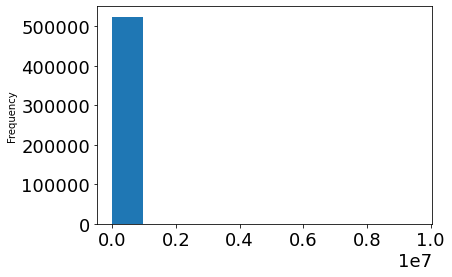


Tracé du KDE avec noyaux gaussiens ViewCount


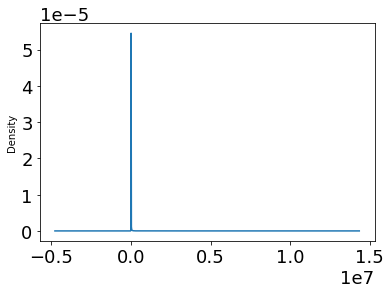


Boxplot représentant les valeurs de la variable ViewCount


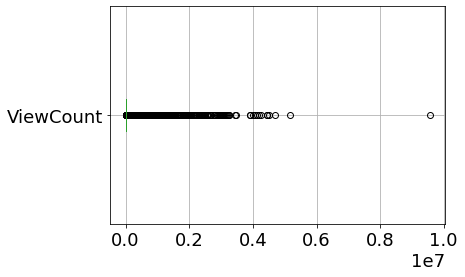

----------------------------------------------------------------------------------------------------


Variable:  AnswerCount

La moyenne de AnswerCount est égale à: 1.7603804611164313
La médiane de AnswerCount est égale à: 1.0
Écart type de AnswerCount est égale à: 2.808509563025949
Quartile Q1 de AnswerCount vaut :  1
Quartile Q3 de AnswerCount vaut :  2
L ecart interquartile vaut :  1
La valeur minimale de AnswerCount est égale à: 0
La valeur maximale de AnswerCount est égale à: 518

Histogramme représentant les valeurs de la variable AnswerCount


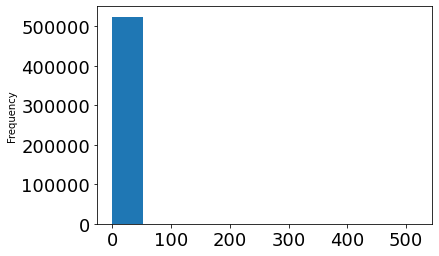


Tracé du KDE avec noyaux gaussiens AnswerCount


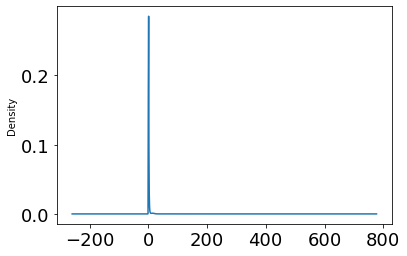


Boxplot représentant les valeurs de la variable AnswerCount


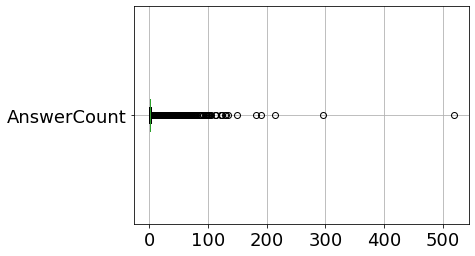

----------------------------------------------------------------------------------------------------


Variable:  Score

La moyenne de Score est égale à: 5.793266387641499
La médiane de Score est égale à: 0.0
Écart type de Score est égale à: 83.52934090661138
Quartile Q1 de Score vaut :  0
Quartile Q3 de Score vaut :  2
L ecart interquartile vaut :  2
La valeur minimale de Score est égale à: -37
La valeur maximale de Score est égale à: 18810

Histogramme représentant les valeurs de la variable Score


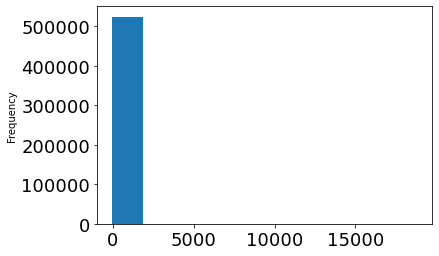


Tracé du KDE avec noyaux gaussiens Score


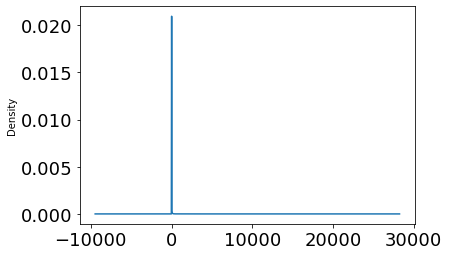


Boxplot représentant les valeurs de la variable Score


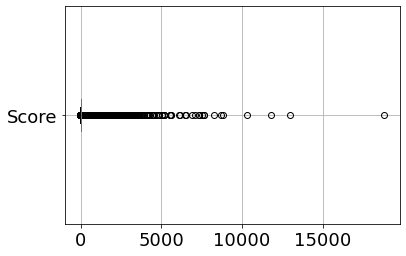

----------------------------------------------------------------------------------------------------




In [65]:
outliers_analyse(df, typage="int64")

In [66]:
col1 = ["ViewCount","AnswerCount","Score"]

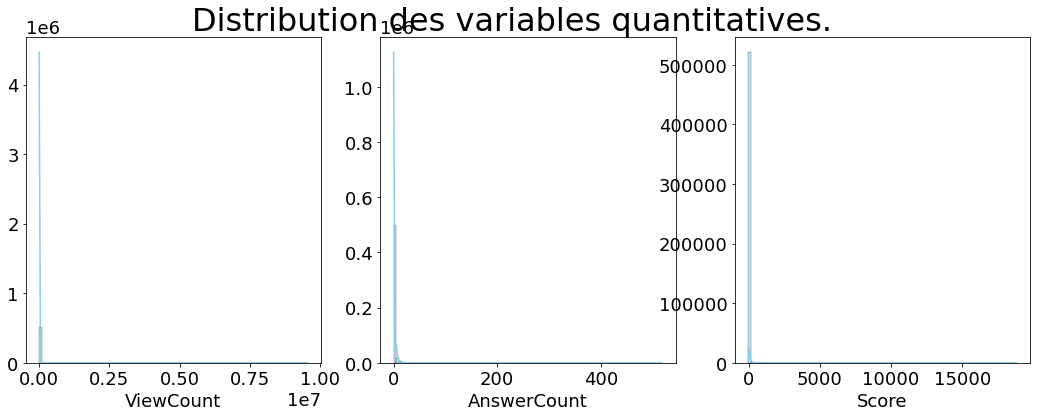

In [67]:
multi_histo(
    df,
    col1,
    3,
    18,
    6,
    colour="skyblue",
    title="Distribution des variables quantitatives.",
)

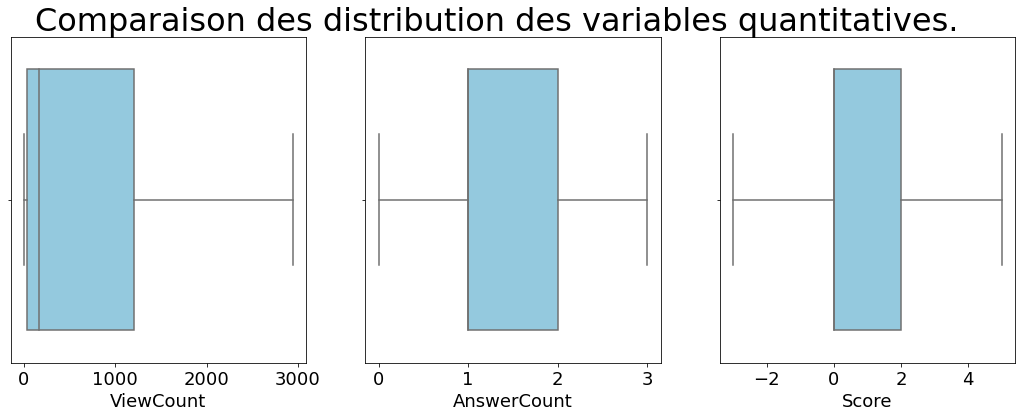

In [68]:
multi_box(
    df,
    col1,
    3,
    18,
    6,
    colour="skyblue",
    title="Comparaison des distribution des variables quantitatives.",
)

#### Suppression des individus ne correspondant pas à une question dite "de qualité" : 

Nous supprimons les individus qui remplissent pas les comditions suivantes :
- valeur de la variable `ViewCount` > et = au 1er Quartile de cette variable c'est à dire 37.
et/ou
- valeur de la variable `AnswerCount` > et = au 1er Quartile de cette variable c'est à dire 1.
et/ou
- valeur de la variable `Score` > et = au 1er Quartile de cette variable c'est à dire 0.

In [69]:
drop_row_var_inf_it(df, name_var="ViewCount", value=37)
drop_row_var_inf_it(df, name_var="AnswerCount", value=1)
drop_row_var_inf_it(df, name_var="Score", value=0)

In [70]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331590 entries, 0 to 523945
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Id            331590 non-null  object        
 1   CreationDate  331590 non-null  datetime64[ns]
 2   Title         331590 non-null  object        
 3   Body          331590 non-null  object        
 4   Tags          331590 non-null  object        
 5   ViewCount     331590 non-null  int64         
 6   AnswerCount   331590 non-null  int64         
 7   Score         331590 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 22.8+ MB


#### Maintenant que nous avons filtré les indivus par la qualité des questions selon les critères de nombre de vues, de nombre de réponses et de scores attribués par la communauté de Stackoverflow, nous allons réaliser un sample afin de ne retenir que 50 000 indiviuds parmi les 331 590 individus de la base de données df : 

In [71]:
df1 = df.sample(n=50000, random_state=42)

In [72]:
df1 = df1.sort_values(by=["CreationDate"])
df1 = df1.reset_index()
df1 = df1.drop(df1.columns[[0]], axis=1)
df1

Id        CreationDate  \
0             4 2008-07-31 21:42:52   
1             9 2008-07-31 23:40:59   
2            17 2008-08-01 05:09:55   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
...         ...                 ...   
49995  70725005 2022-01-15 20:05:04   
49996  70725560 2022-01-15 21:24:12   
49997  70725976 2022-01-15 22:33:40   
49998  70727148 2022-01-16 03:24:12   
49999  70727243 2022-01-16 03:52:02   

                                                   Title  \
0            How to convert a Decimal to a Double in C#?   
1      How do I calculate someone's age based on a Da...   
2                                   Binary Data in MySQL   
3      How do I get a distinct, ordered list of names...   
4      Microsoft Office 2007 file type, Mime types an...   
...                                                  ...   
49995      Declaring stringstream crashes the app in C++   
49996    return reference in cpp function returns a copy   
49997  How to make a reference to a concrete subtype ...   
49998  How to count the number of Strings in localSto...   
49999  How to initialize to an empty array if my 'stu...   

                                                    Body  \
0      <p>I want to use a <code>Track-Bar</code> to c...   
1      <p>Given a <code>DateTime</code> representing ...   
2      <p>How do I store binary data in <a href="http...   
3      <p>I have a <code>DataTable</code> with a <cod...   
4      <p>Where can I find a list of all of the MIME ...   
...                                                  ...   
49995  <p>So, in one of my projects, I was trying to ...   
49996  <p>I am trying to return the reference of the ...   
49997  <p>Suppose I have the following definition:</p...   
49998  <p>Can anyone tell me how to count the number ...   
49999  <p>I am attempting to write code For the Bootc...   

                                                    Tags  ViewCount  \
0      <c#><floating-point><type-conversion><double><...      62551   
1                                   <c#><.net><datetime>     716062   
2           <mysql><database><binary-data><data-storage>      82868   
3                                   <c#><linq><.net-3.5>      26384   
4                         <mime><file-type><office-2007>       3892   
...                                                  ...        ...   
49995                                <c++><stringstream>         40   
49996                                              <c++>         73   
49997                                   <java><generics>         41   
49998                                       <javascript>         38   
49999                      <javascript><arrays><reactjs>         37   

       AnswerCount  Score  
0               12    752  
1               69   2081  
2                9    194  
3                7    112  
4                1     50  
...            ...    ...  
49995            1      0  
49996            2      1  
49997            1      0  
49998            2      1  
49999            2      0  

[50000 rows x 8 columns]

In [73]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            50000 non-null  object        
 1   CreationDate  50000 non-null  datetime64[ns]
 2   Title         50000 non-null  object        
 3   Body          50000 non-null  object        
 4   Tags          50000 non-null  object        
 5   ViewCount     50000 non-null  int64         
 6   AnswerCount   50000 non-null  int64         
 7   Score         50000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 3.1+ MB


#### Période d'étallement de notre base de données df :

In [74]:
time_delta = int(
    (df1["CreationDate"].max() - df1["CreationDate"].min()) / np.timedelta64(1, "Y")
)
print(
    "La période dont nous disposons est de",
    time_delta,
    "ans, elle commence le",
    df1["CreationDate"].min(),
    "et se termine le",
    df1["CreationDate"].max(),
    ".",
)

La période dont nous disposons est de 13 ans, elle commence le 2008-07-31 21:42:52 et se termine le 2022-01-16 03:52:02 .


#### Visualisation de la longueur du corps de texte de la variable `Body` et de la variable `Title`:

##### Variable `Body` :

In [75]:
X = pd.DataFrame(df1.Body.str.len())  # Discretizer for Body characters lenght

discretizer = KBinsDiscretizer(
    n_bins=50, encode="ordinal", strategy="uniform"
)  # Sklearn discretizer with 50 bins
body_lenght = discretizer.fit_transform(X)
body_lenght = discretizer.inverse_transform(body_lenght)
body_lenght = pd.Series(body_lenght.reshape(-1))

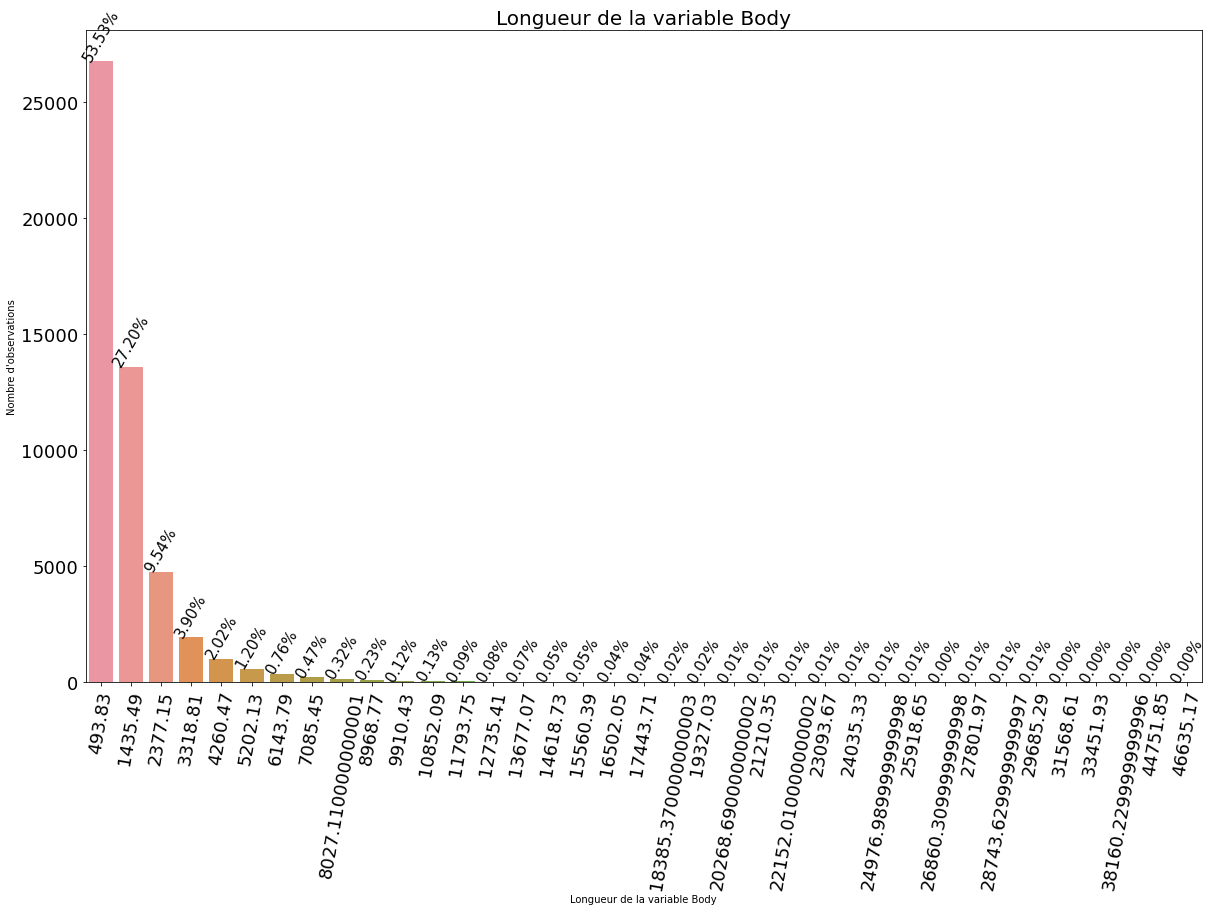

In [76]:
fig = plt.figure(figsize=(20, 12))
total = float(len(body_lenght))
ax = sns.countplot(x=body_lenght)
ax.set_xlabel("Longueur de la variable Body")
ax.set_ylabel("Nombre d'observations")
plt.title("Longueur de la variable Body", fontsize=20)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 30,
        "{:.2%}".format(height / total),
        ha="center",
        rotation=60,
        fontsize=15,
    )
    plt.xticks(rotation=80)
plt.show()

##### Variable `Title` :

In [77]:
X = pd.DataFrame(df1.Title.str.len())  # Discretizer for Title characters lenght

discretizer = KBinsDiscretizer(
    n_bins=50, encode="ordinal", strategy="uniform"
)  # Sklearn discretizer with 50 bins
title_lenght = discretizer.fit_transform(X)
title_lenght = discretizer.inverse_transform(title_lenght)
title_lenght = pd.Series(title_lenght.reshape(-1))

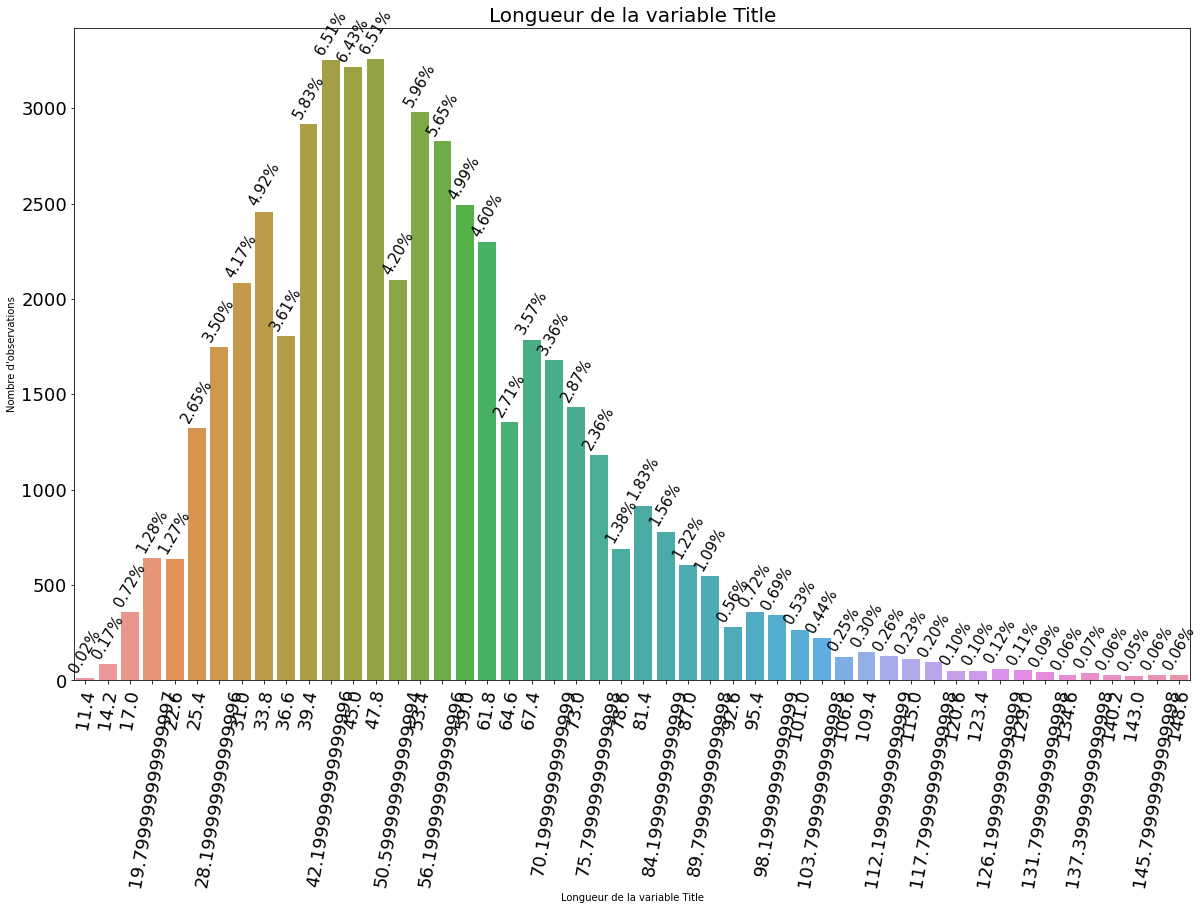

In [78]:
fig = plt.figure(figsize=(20, 12))
total = float(len(title_lenght))
ax = sns.countplot(x=title_lenght)
ax.set_xlabel("Longueur de la variable Title")
ax.set_ylabel("Nombre d'observations")
plt.title("Longueur de la variable Title", fontsize=20)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 30,
        "{:.2%}".format(height / total),
        ha="center",
        rotation=60,
        fontsize=15,
    )
    plt.xticks(rotation=80)
plt.show()

#### Création de la variable `question` qui comprend les valeurs des variables `Body` et `Title`et de la variable `tag`qui comprend les valeurs de la variable `Tags`ces deux variables sont créées et nettoyées de leurs symboles HTML :

In [79]:
df1["title"] = df1["Title"].apply(lower)
df1["title"] = [re.sub("c#","csharp", x) for x in df1.title]
df1["title"] = [re.sub("\.net","dotnet", x) for x in df1.title]
df1["title"] = [re.sub("\.js","dotjs", x) for x in df1.title]
df1["title"] = [re.sub("windows\11","windowseleven", x) for x in df1.title]
df1["title"] = [re.sub("windows\10","windowsten", x) for x in df1.title]
#df1["title"] = [re.sub("windows\8","windowseight", x) for x in df1.title]
df1["title"] = [re.sub("windows\7","windowsseven", x) for x in df1.title]
df1["title"] = [re.sub("windows\365","windowsthreehundredsixtyfive", x) for x in df1.title]
df1["title"] = [re.sub("x11","xeleven", x) for x in df1.title]
df1["title"] = [re.sub("office\2000","officetwothousand", x) for x in df1.title]
df1["title"] = [re.sub("office\2003","officetwothousandthree", x) for x in df1.title]
df1["title"] = [re.sub("office\2007","officetwothousandseven", x) for x in df1.title]
df1["title"] = [re.sub("office\2010","officetwothousandten", x) for x in df1.title]
df1["title"] = [re.sub("office\2013","officetwothousandthirteen", x) for x in df1.title]
df1["title"] = [re.sub("office\2016","officetwothousandsixteen", x) for x in df1.title]
df1["title"] = [re.sub("office\2019","officetwothousandnineteen", x) for x in df1.title]
df1["title"] = [re.sub("ms","microsoft", x) for x in df1.title]
df1["title"] = [re.sub("<.*?>", " ", x) for x in df1.title]  # replace HTML tags by ' '
df1["title"] = [
    re.sub(r"&(\w+);", " ", x) for x in df1.title
]  # replace HTML symbols (&quot; &lt; &gt; ...) by ' '
df1["body"] = df1["Body"].apply(lower)
df1["body"] = [re.sub("c#","csharp", x) for x in df1.body]
df1["body"] = [re.sub("\.net","dotnet", x) for x in df1.body]
df1["body"] = [re.sub("\.js","dotjs", x) for x in df1.body]
df1["body"] = [re.sub("windows\11","windowseleven", x) for x in df1.body]
df1["body"] = [re.sub("windows\10","windowsten", x) for x in df1.body]
#df1["body"] = [re.sub("windows\8","windowseight", x) for x in df1.body]
df1["body"] = [re.sub("windows\7","windowsseven", x) for x in df1.body]
df1["body"] = [re.sub("windows\365","windowsthreehundredsixtyfive", x) for x in df1.body]
df1["body"] = [re.sub("x11","xeleven", x) for x in df1.body]
df1["body"] = [re.sub("office\2000","officetwothousand", x) for x in df1.body]
df1["body"] = [re.sub("office\2003","officetwothousandthree", x) for x in df1.body]
df1["body"] = [re.sub("office\2007","officetwothousandseven", x) for x in df1.body]
df1["body"] = [re.sub("office\2010","officetwothousandten", x) for x in df1.body]
df1["body"] = [re.sub("office\2013","officetwothousandthirteen", x) for x in df1.body]
df1["body"] = [re.sub("office\2016","officetwothousandsixteen", x) for x in df1.body]
df1["body"] = [re.sub("office\2019","officetwothousandnineteen", x) for x in df1.body]
df1["body"] = [re.sub("ms","microsoft", x) for x in df1.body]
df1["body"] = [re.sub("<.*?>", " ", x) for x in df1.body]  # replace HTML tags by ' '
df1["body"] = [
    re.sub(r"&(\w+);", " ", x) for x in df1.body
]  # replace HTML symbols (&quot; &lt; &gt; ...) by ' '
df1["body"] = [
    re.sub("<p>", " ", x) for x in df1.body
]  # replace HTML symbols (<p>; ...) by ' '
df1["body"] = [BeautifulSoup(text, "lxml").get_text() for text in df1["body"]]
df1["question"] = df1.title + " " + df1.body
df1["question"] = [
    re.sub("<.*?>", " ", x) for x in df1.question
]  # replace HTML tags by ' '
df1["question"] = [
    re.sub(r"&(\w+);", " ", x) for x in df1.question
]  # replace HTML symbols (&quot; &lt; &gt; ...) by ' '
df1["tag"] = df1["Tags"].apply(lower)
df1["tag"] = [re.sub("<", " ", x) for x in df1.tag]  # get the list of values without <
df1["tag"] = [re.sub(">", " ", x) for x in df1.tag]  # get the list of values without >
df1["tag"] = [re.sub("asp.net","aspnet", x) for x in df1.tag]
df1["tag"] = [re.sub("asp.net-mvc","aspnetmvc", x) for x in df1.tag]
df1["tag"] = [re.sub("c#","csharp", x) for x in df1.tag]
df1["tag"] = [re.sub("\.net","dotnet", x) for x in df1.tag]
df1["tag"] = [re.sub("\.js","dotjs", x) for x in df1.tag]
df1["tag"] = [re.sub("windows11","windowseleven", x) for x in df1.tag]
df1["tag"] = [re.sub("windows10","windowsten", x) for x in df1.tag]
df1["tag"] = [re.sub("windows8","windowseight", x) for x in df1.tag]
df1["tag"] = [re.sub("windows7","windowsseven", x) for x in df1.tag]
df1["tag"] = [re.sub("windows365","windowsthreehundredsixtyfive", x) for x in df1.tag]
df1["tag"] = [re.sub("x11","xeleven", x) for x in df1.tag]
df1["tag"] = [re.sub("office2000","officetwothousand", x) for x in df1.tag]
df1["tag"] = [re.sub("office2003","officetwothousandthree", x) for x in df1.tag]
df1["tag"] = [re.sub("office2007","officetwothousandseven", x) for x in df1.tag]
df1["tag"] = [re.sub("office2010","officetwothousandten", x) for x in df1.tag]
df1["tag"] = [re.sub("office2013","officetwothousandthirteen", x) for x in df1.tag]
df1["tag"] = [re.sub("office2016","officetwothousandsixteen", x) for x in df1.tag]
df1["tag"] = [re.sub("office2019","officetwothousandnineteen", x) for x in df1.tag]
df1["tag"] = [re.sub("ipv4","ipvfor", x) for x in df1.tag]
df1["tag"] = [re.sub("ipv6","ipvsix", x) for x in df1.tag]
df1["tag"] = [re.sub("2d","twodimensions", x) for x in df1.tag]
df1["tag"] = [re.sub("3d","threedimensions", x) for x in df1.tag]
df1["tag"] = [re.sub("4d","fordimensions", x) for x in df1.tag]
df1["tag"] = [re.sub("caff2","cafftwo", x) for x in df1.tag]
df1["tag"] = [re.sub("\.io","dotio", x) for x in df1.tag]
df1["tag"] = [re.sub("\.com","dotcom", x) for x in df1.tag]
df1["tag"] = [re.sub("objective-c","objectivec", x) for x in df1.tag]
df1["tag"] = [re.sub("f#","fsharp", x) for x in df1.tag]
df1["tag"] = [re.sub("ms","microsoft", x) for x in df1.tag]
df1["tag"] = [re.sub("-", " ", x) for x in df1.tag]  # get the list of values without -
df1["tag"] = [re.sub("[^a-zA-Z+]", " ", x) for x in df1.tag]

In [80]:
df1

Id        CreationDate  \
0             4 2008-07-31 21:42:52   
1             9 2008-07-31 23:40:59   
2            17 2008-08-01 05:09:55   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
...         ...                 ...   
49995  70725005 2022-01-15 20:05:04   
49996  70725560 2022-01-15 21:24:12   
49997  70725976 2022-01-15 22:33:40   
49998  70727148 2022-01-16 03:24:12   
49999  70727243 2022-01-16 03:52:02   

                                                   Title  \
0            How to convert a Decimal to a Double in C#?   
1      How do I calculate someone's age based on a Da...   
2                                   Binary Data in MySQL   
3      How do I get a distinct, ordered list of names...   
4      Microsoft Office 2007 file type, Mime types an...   
...                                                  ...   
49995      Declaring stringstream crashes the app in C++   
49996    return reference in cpp function returns a copy   
49997  How to make a reference to a concrete subtype ...   
49998  How to count the number of Strings in localSto...   
49999  How to initialize to an empty array if my 'stu...   

                                                    Body  \
0      <p>I want to use a <code>Track-Bar</code> to c...   
1      <p>Given a <code>DateTime</code> representing ...   
2      <p>How do I store binary data in <a href="http...   
3      <p>I have a <code>DataTable</code> with a <cod...   
4      <p>Where can I find a list of all of the MIME ...   
...                                                  ...   
49995  <p>So, in one of my projects, I was trying to ...   
49996  <p>I am trying to return the reference of the ...   
49997  <p>Suppose I have the following definition:</p...   
49998  <p>Can anyone tell me how to count the number ...   
49999  <p>I am attempting to write code For the Bootc...   

                                                    Tags  ViewCount  \
0      <c#><floating-point><type-conversion><double><...      62551   
1                                   <c#><.net><datetime>     716062   
2           <mysql><database><binary-data><data-storage>      82868   
3                                   <c#><linq><.net-3.5>      26384   
4                         <mime><file-type><office-2007>       3892   
...                                                  ...        ...   
49995                                <c++><stringstream>         40   
49996                                              <c++>         73   
49997                                   <java><generics>         41   
49998                                       <javascript>         38   
49999                      <javascript><arrays><reactjs>         37   

       AnswerCount  Score                                              title  \
0               12    752    how to convert a decimal to a double in csharp?   
1               69   2081  how do i calculate someone's age based on a da...   
2                9    194                               binary data in mysql   
3                7    112  how do i get a distinct, ordered list of names...   
4                1     50  microsoft office 2007 file type, mime types an...   
...            ...    ...                                                ...   
49995            1      0      declaring stringstream crashes the app in c++   
49996            2      1    return reference in cpp function returns a copy   
49997            1      0  how to make a reference to a concrete subtype ...   
49998            2      1  how to count the number of strings in localsto...   
49999            2      0  how to initialize to an empty array if my 'stu...   

                                                    body  \
0      i want to use a  track-bar  to change a  form ...   
1      given a  datetime  representing a person's bir...   
2              how do i store binary data in  mysql ? \n   
3      i have a  datatable  with a  name  column

#### Visualisation de la longueur du corps de texte de la variable `question`:

In [81]:
X = pd.DataFrame(df1.question.str.len())  # Discretizer for Title characters lenght

discretizer = KBinsDiscretizer(
    n_bins=50, encode="ordinal", strategy="uniform"
)  # Sklearn discretizer with 50 bins
question_lenght = discretizer.fit_transform(X)
question_lenght = discretizer.inverse_transform(question_lenght)
question_lenght = pd.Series(question_lenght.reshape(-1))

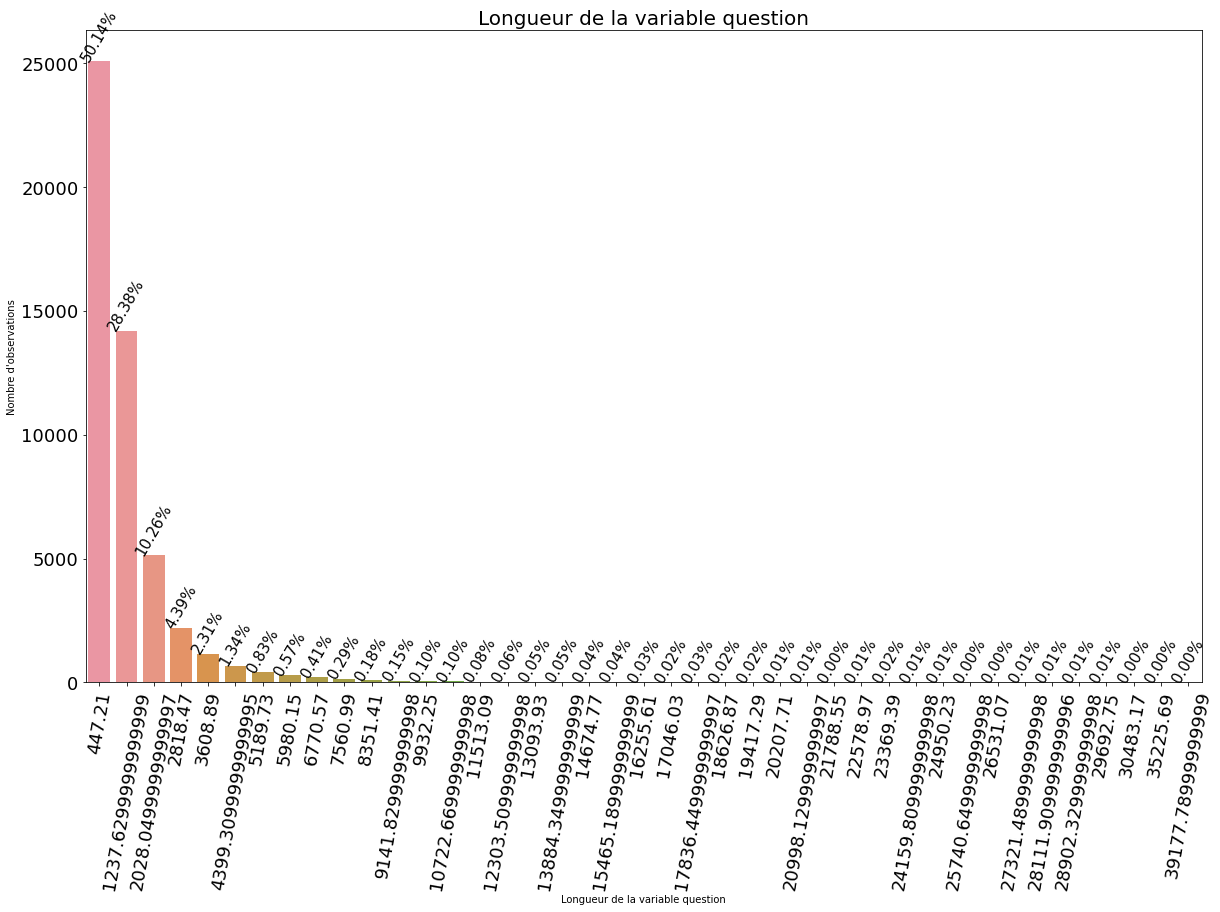

In [82]:
fig = plt.figure(figsize=(20, 12))
total = float(len(question_lenght))
ax = sns.countplot(x=question_lenght)
ax.set_xlabel("Longueur de la variable question")
ax.set_ylabel("Nombre d'observations")
plt.title("Longueur de la variable question", fontsize=20)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 30,
        "{:.2%}".format(height / total),
        ha="center",
        rotation=60,
        fontsize=15,
    )
    plt.xticks(rotation=80)
plt.show()

##### Nous observons qu'une grande majorité des questions (Body + Title) compte moins de 5 000 caractères :

Certaines questions (Body + Title) comptent plus de 20 000 caractères. Afin de fluidifier les processus suivants, nous ne conservons que les questions comptant moins de 5 000 caractères.

In [83]:
df1 = df1[df1.question.str.len() < 5000]
df1 = df1.reset_index()
df1 = df1.drop(df1.columns[[0]], axis=1)
df1.shape

(48533, 12)

#### Features Engineering : création des variables représentant le nombre de tags, le nombre de mots par title, body et question :

In [84]:
# counting words
df1["nb_w_title"] = [len(x.split()) for x in df1.title]
# counting words
df1["nb_w_body"] = [len(x.split()) for x in df1.body]
# counting words
df1["nb_w_quest"] = [len(x.split()) for x in df1.question]
# counting tags
df1["nb_tag"] = [len(x.split()) for x in df1.tag]

In [85]:
df1

Id        CreationDate  \
0             4 2008-07-31 21:42:52   
1             9 2008-07-31 23:40:59   
2            17 2008-08-01 05:09:55   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
...         ...                 ...   
48528  70725005 2022-01-15 20:05:04   
48529  70725560 2022-01-15 21:24:12   
48530  70725976 2022-01-15 22:33:40   
48531  70727148 2022-01-16 03:24:12   
48532  70727243 2022-01-16 03:52:02   

                                                   Title  \
0            How to convert a Decimal to a Double in C#?   
1      How do I calculate someone's age based on a Da...   
2                                   Binary Data in MySQL   
3      How do I get a distinct, ordered list of names...   
4      Microsoft Office 2007 file type, Mime types an...   
...                                                  ...   
48528      Declaring stringstream crashes the app in C++   
48529    return reference in cpp function returns a copy   
48530  How to make a reference to a concrete subtype ...   
48531  How to count the number of Strings in localSto...   
48532  How to initialize to an empty array if my 'stu...   

                                                    Body  \
0      <p>I want to use a <code>Track-Bar</code> to c...   
1      <p>Given a <code>DateTime</code> representing ...   
2      <p>How do I store binary data in <a href="http...   
3      <p>I have a <code>DataTable</code> with a <cod...   
4      <p>Where can I find a list of all of the MIME ...   
...                                                  ...   
48528  <p>So, in one of my projects, I was trying to ...   
48529  <p>I am trying to return the reference of the ...   
48530  <p>Suppose I have the following definition:</p...   
48531  <p>Can anyone tell me how to count the number ...   
48532  <p>I am attempting to write code For the Bootc...   

                                                    Tags  ViewCount  \
0      <c#><floating-point><type-conversion><double><...      62551   
1                                   <c#><.net><datetime>     716062   
2           <mysql><database><binary-data><data-storage>      82868   
3                                   <c#><linq><.net-3.5>      26384   
4                         <mime><file-type><office-2007>       3892   
...                                                  ...        ...   
48528                                <c++><stringstream>         40   
48529                                              <c++>         73   
48530                                   <java><generics>         41   
48531                                       <javascript>         38   
48532                      <javascript><arrays><reactjs>         37   

       AnswerCount  Score                                              title  \
0               12    752    how to convert a decimal to a double in csharp?   
1               69   2081  how do i calculate someone's age based on a da...   
2                9    194                               binary data in mysql   
3                7    112  how do i get a distinct, ordered list of names...   
4                1     50  microsoft office 2007 file type, mime types an...   
...            ...    ...                                                ...   
48528            1      0      declaring stringstream crashes the app in c++   
48529            2      1    return reference in cpp function returns a copy   
48530            1      0  how to make a reference to a concrete subtype ...   
48531            2      1  how to count the number of strings in localsto...   
48532            2      0  how to initialize to an empty array if my 'stu...   

                                                    body  \
0      i want to use a  track-bar  to change a  form ...   
1      given a  datetime  representing a person's bir...   
2              how do i store binary data in  mysql ? \n   
3      i have a  datatable  with a  name  column

In [86]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48533 entries, 0 to 48532
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            48533 non-null  object        
 1   CreationDate  48533 non-null  datetime64[ns]
 2   Title         48533 non-null  object        
 3   Body          48533 non-null  object        
 4   Tags          48533 non-null  object        
 5   ViewCount     48533 non-null  int64         
 6   AnswerCount   48533 non-null  int64         
 7   Score         48533 non-null  int64         
 8   title         48533 non-null  object        
 9   body          48533 non-null  object        
 10  question      48533 non-null  object        
 11  tag           48533 non-null  object        
 12  nb_w_title    48533 non-null  int64         
 13  nb_w_body     48533 non-null  int64         
 14  nb_w_quest    48533 non-null  int64         
 15  nb_tag        48533 non-null  int64 

In [87]:
print("Nb de valeurs manquantes par variables :\n", df1.isna().sum(), "\n")

Nb de valeurs manquantes par variables :
 Id              0
CreationDate    0
Title           0
Body            0
Tags            0
ViewCount       0
AnswerCount     0
Score           0
title           0
body            0
question        0
tag             0
nb_w_title      0
nb_w_body       0
nb_w_quest      0
nb_tag          0
dtype: int64 



In [88]:
df1["Id"] = df1["Id"].astype("object")

#### Analyse univariée des nouvelles variables quantitatives :

Variable:  ViewCount

La moyenne de ViewCount est égale à: 9108.299260297117
La médiane de ViewCount est égale à: 660.0
Écart type de ViewCount est égale à: 80757.02788711234
Quartile Q1 de ViewCount vaut :  128
Quartile Q3 de ViewCount vaut :  2597
L ecart interquartile vaut :  2469
La valeur minimale de ViewCount est égale à: 37
La valeur maximale de ViewCount est égale à: 9565807

Histogramme représentant les valeurs de la variable ViewCount


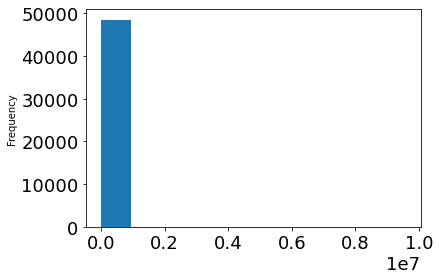


Tracé du KDE avec noyaux gaussiens ViewCount


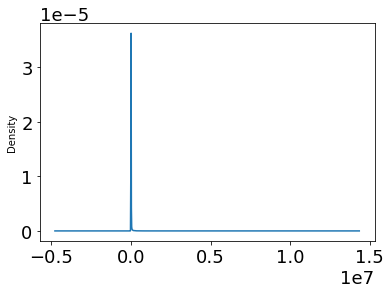


Boxplot représentant les valeurs de la variable ViewCount


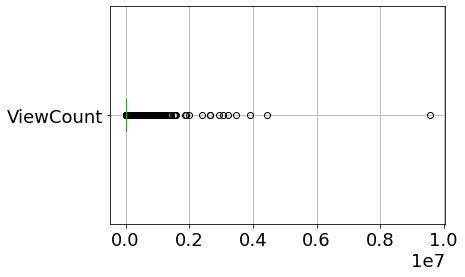

----------------------------------------------------------------------------------------------------


Variable:  AnswerCount

La moyenne de AnswerCount est égale à: 2.5023386149630147
La médiane de AnswerCount est égale à: 2.0
Écart type de AnswerCount est égale à: 4.156203203324146
Quartile Q1 de AnswerCount vaut :  1
Quartile Q3 de AnswerCount vaut :  3
L ecart interquartile vaut :  2
La valeur minimale de AnswerCount est égale à: 1
La valeur maximale de AnswerCount est égale à: 518

Histogramme représentant les valeurs de la variable AnswerCount


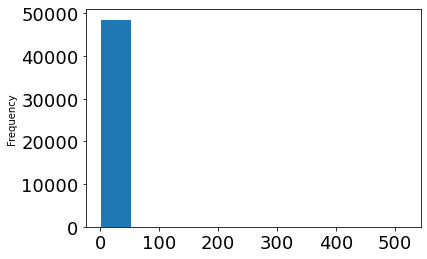


Tracé du KDE avec noyaux gaussiens AnswerCount


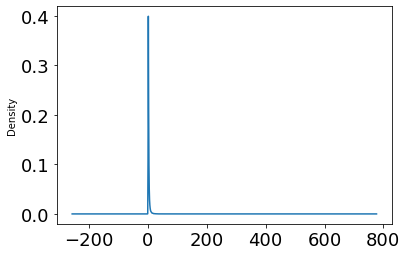


Boxplot représentant les valeurs de la variable AnswerCount


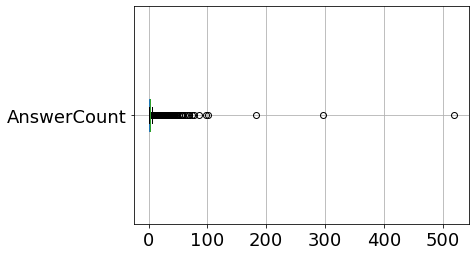

----------------------------------------------------------------------------------------------------


Variable:  Score

La moyenne de Score est égale à: 9.819442441225558
La médiane de Score est égale à: 1.0
Écart type de Score est égale à: 128.78836348574583
Quartile Q1 de Score vaut :  0
Quartile Q3 de Score vaut :  3
L ecart interquartile vaut :  3
La valeur minimale de Score est égale à: 0
La valeur maximale de Score est égale à: 18810

Histogramme représentant les valeurs de la variable Score


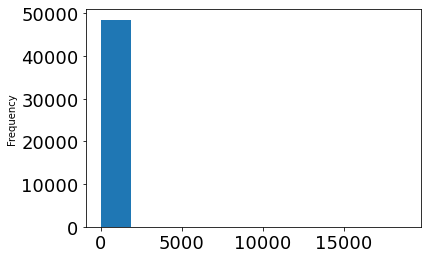


Tracé du KDE avec noyaux gaussiens Score


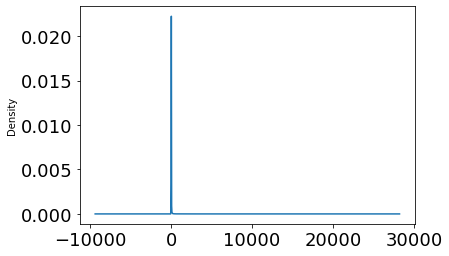


Boxplot représentant les valeurs de la variable Score


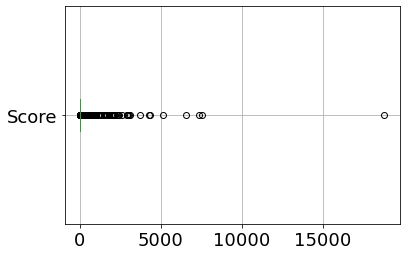

----------------------------------------------------------------------------------------------------


Variable:  nb_w_title

La moyenne de nb_w_title est égale à: 8.81674324686296
La médiane de nb_w_title est égale à: 8.0
Écart type de nb_w_title est égale à: 3.7529353725803043
Quartile Q1 de nb_w_title vaut :  6
Quartile Q3 de nb_w_title vaut :  11
L ecart interquartile vaut :  5
La valeur minimale de nb_w_title est égale à: 0
La valeur maximale de nb_w_title est égale à: 31

Histogramme représentant les valeurs de la variable nb_w_title


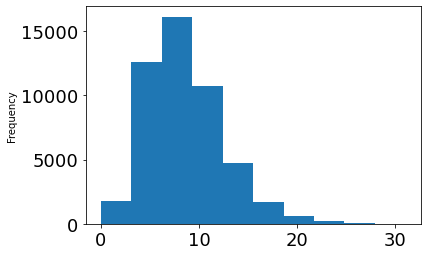


Tracé du KDE avec noyaux gaussiens nb_w_title


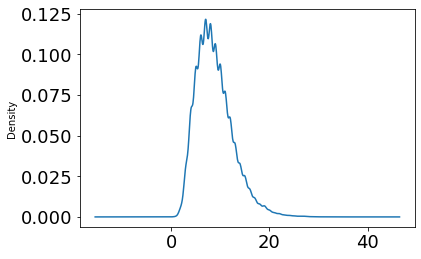


Boxplot représentant les valeurs de la variable nb_w_title


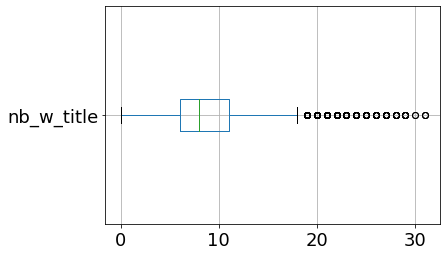

----------------------------------------------------------------------------------------------------


Variable:  nb_w_body

La moyenne de nb_w_body est égale à: 137.438485154431
La médiane de nb_w_body est égale à: 111.0
Écart type de nb_w_body est égale à: 98.99828098986346
Quartile Q1 de nb_w_body vaut :  67
Quartile Q3 de nb_w_body vaut :  178
L ecart interquartile vaut :  111
La valeur minimale de nb_w_body est égale à: 1
La valeur maximale de nb_w_body est égale à: 955

Histogramme représentant les valeurs de la variable nb_w_body


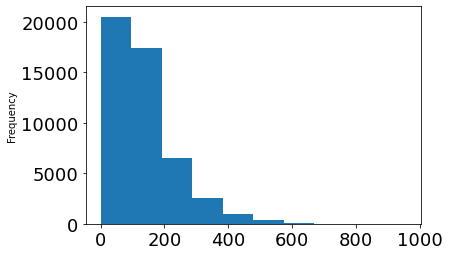


Tracé du KDE avec noyaux gaussiens nb_w_body


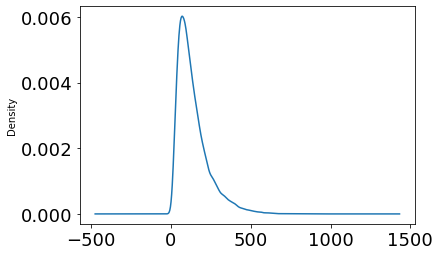


Boxplot représentant les valeurs de la variable nb_w_body


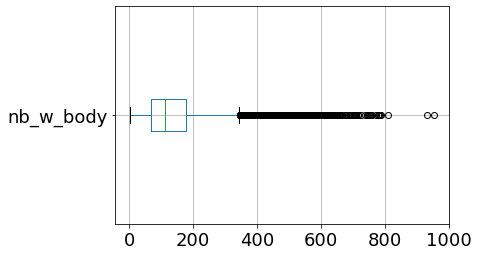

----------------------------------------------------------------------------------------------------


Variable:  nb_w_quest

La moyenne de nb_w_quest est égale à: 146.25444542888343
La médiane de nb_w_quest est égale à: 120.0
Écart type de nb_w_quest est égale à: 99.37439755998749
Quartile Q1 de nb_w_quest vaut :  76
Quartile Q3 de nb_w_quest vaut :  187
L ecart interquartile vaut :  111
La valeur minimale de nb_w_quest est égale à: 8
La valeur maximale de nb_w_quest est égale à: 968

Histogramme représentant les valeurs de la variable nb_w_quest


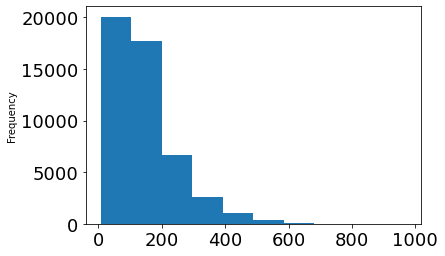


Tracé du KDE avec noyaux gaussiens nb_w_quest


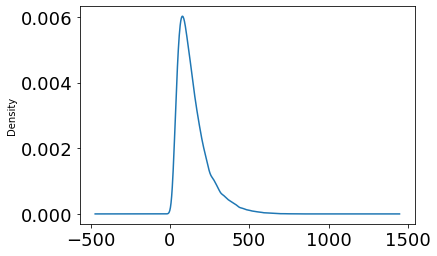


Boxplot représentant les valeurs de la variable nb_w_quest


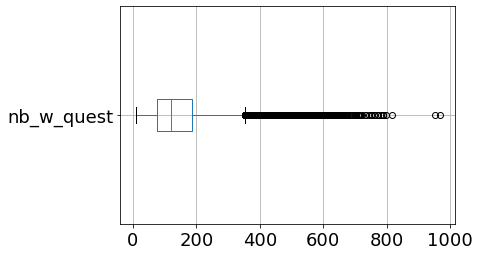

----------------------------------------------------------------------------------------------------


Variable:  nb_tag

La moyenne de nb_tag est égale à: 3.7281437372509427
La médiane de nb_tag est égale à: 4.0
Écart type de nb_tag est égale à: 1.8240131561600268
Quartile Q1 de nb_tag vaut :  2
Quartile Q3 de nb_tag vaut :  5
L ecart interquartile vaut :  3
La valeur minimale de nb_tag est égale à: 1
La valeur maximale de nb_tag est égale à: 14

Histogramme représentant les valeurs de la variable nb_tag


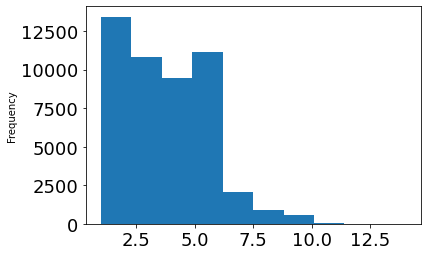


Tracé du KDE avec noyaux gaussiens nb_tag


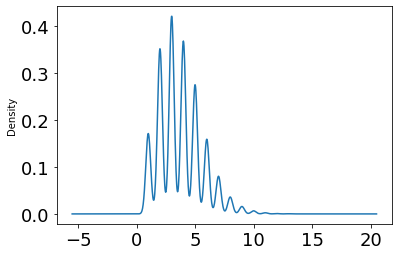


Boxplot représentant les valeurs de la variable nb_tag


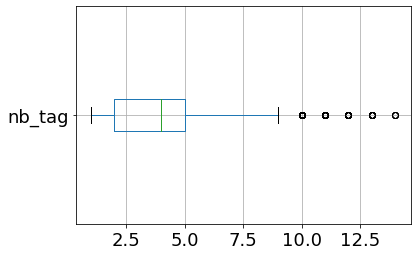

----------------------------------------------------------------------------------------------------




In [89]:
outliers_analyse(df1, typage="int64")

In [90]:
col1 = ["nb_w_title", "nb_w_body", "nb_w_quest", "nb_tag"]

In [91]:
from math import ceil, sqrt, floor

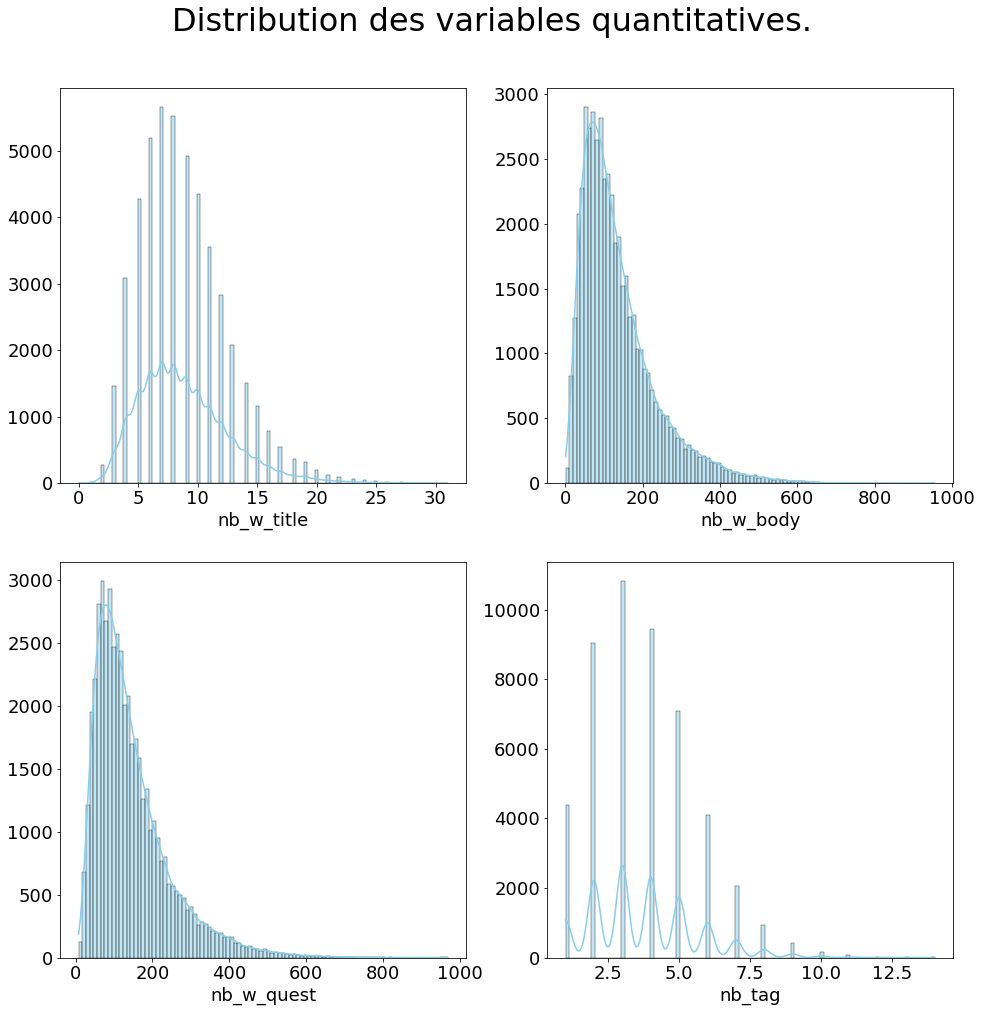

In [92]:
multi_histo(
    df1,
    col1,
    2,
    16,
    16,
    colour="skyblue",
    title="Distribution des variables quantitatives.",
)

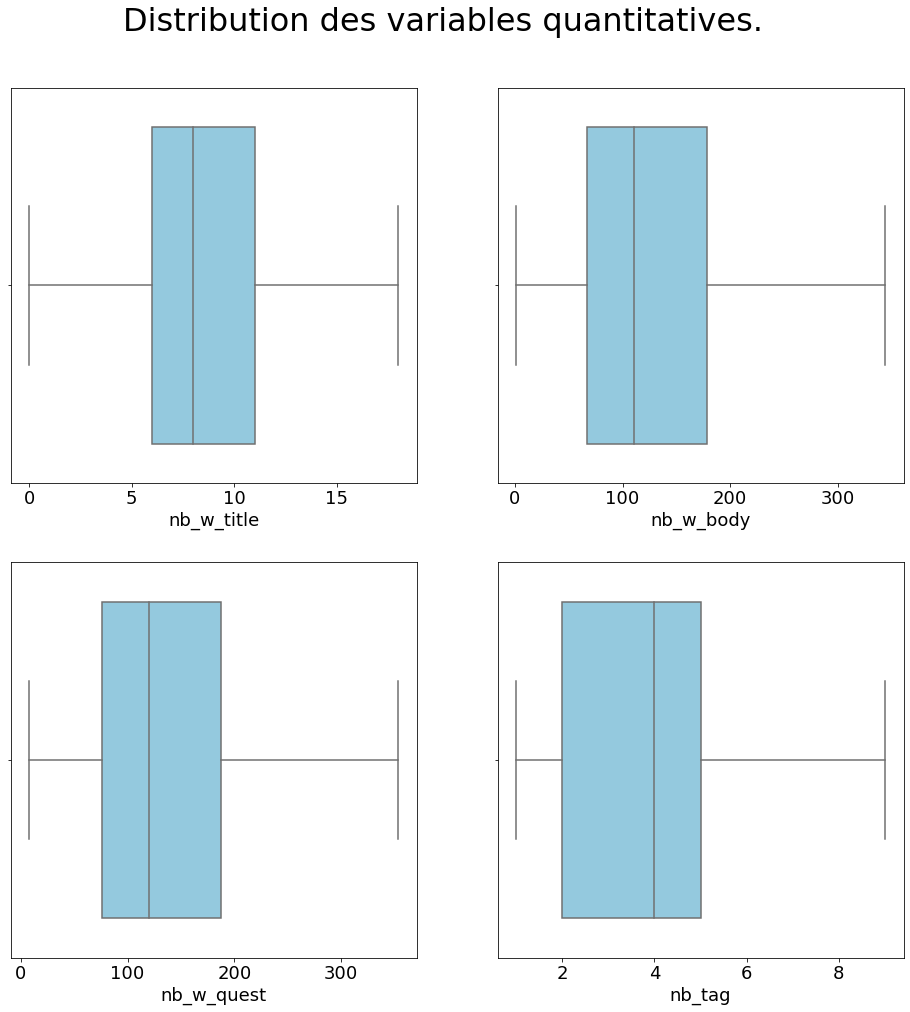

In [93]:
multi_box(
    df1,
    col1,
    2,
    16,
    16,
    colour="skyblue",
    title="Distribution des variables quantitatives.",
)

#### Analyse bivariée de l'ensemble des variables quantitatives :

<AxesSubplot:title={'center':'Matrice de corrélation'}>

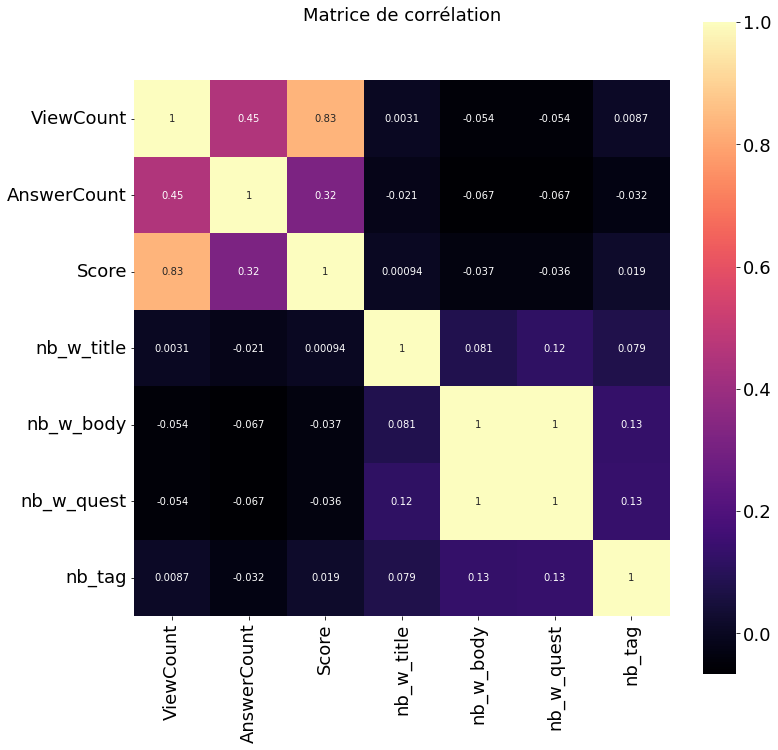

In [94]:
dcorr = df1.corr()
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Matrice de corrélation", fontdict={"fontsize": 18}, x=0.5, y=1.1)
sns.heatmap(
    dcorr, annot=True, square=True, cmap=sns.color_palette("magma", as_cmap=True), ax=ax
)

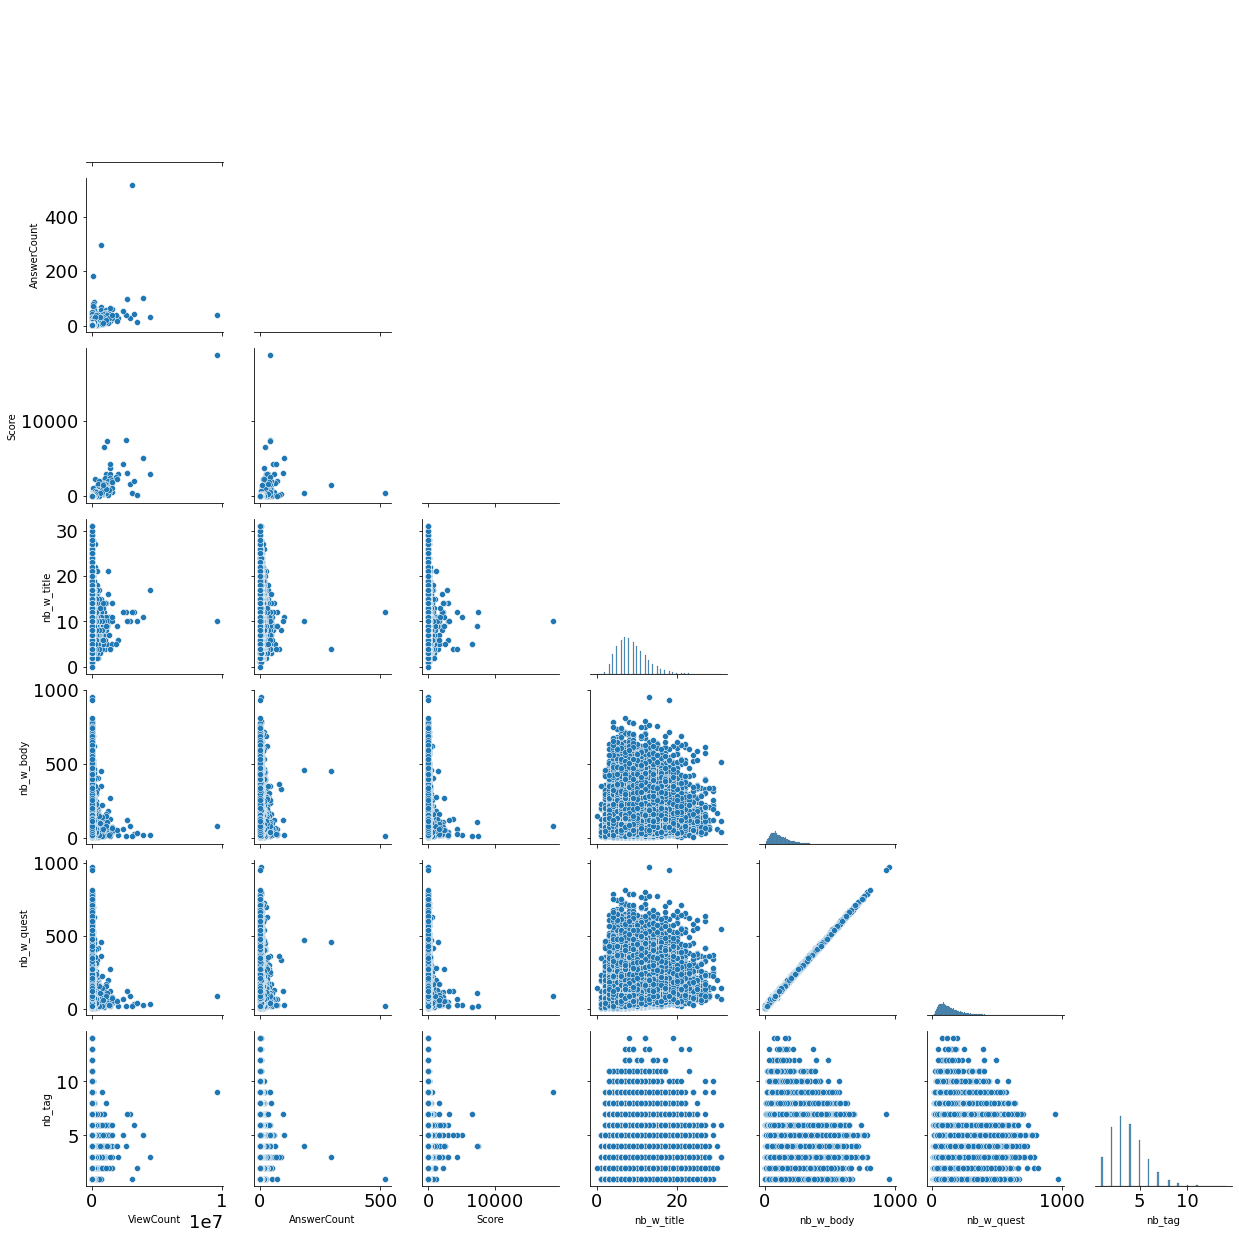

In [95]:
d = ["ViewCount","AnswerCount","Score","nb_w_title", "nb_w_body", "nb_w_quest", "nb_tag"]
g = sns.pairplot(df1[d], diag_kind="hist", corner=True)

Au des résultats précedents, nous observons que le nombre de tag n'est pas corrélé au nombre de mots contenus dans le corps des titres, ni dans au nombre de mots contenus dans le corps des questions et ni au nombre de mots résultant de la somme des corps des titres avec ceux des questions. Par, contre nous observons une corrélation du nombre de vue avec le scrore de la question et une corrélation entre le nombre de mots de la variable `question`et le nombre de mots de la variable `body`ce qui n'est pas étonnant étant donné que la première variable est issue de la seconde variable.

In [96]:
df11 = df1[df1["nb_tag"] > 1]

In [97]:
df11.shape

(44134, 16)

In [98]:
df111 = df11[df11["nb_tag"] < 5]

In [99]:
df111.shape

(29315, 16)

####  Tokenisation des variables `question` et `tag` :

In [100]:
df2 = df111.copy()

In [101]:
df3 = df111.copy()

In [102]:
df2["question_norm"] = df2["question"].apply(code_norm)

In [103]:
df2["question_tok"] = df2["question_norm"].apply(tokenize_text)

In [104]:
df2["tag_norm"] = df2["tag"].apply(code_norm)

In [105]:
df2["tag_tok"] = df2["tag_norm"].apply(tokenize_text)

In [106]:
df2["tag_norm"] = df2["tag"].apply(code_norm)
df2["tag_tok"] = df2["tag_norm"].apply(tokenize_text)

In [107]:
df2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29315 entries, 1 to 48532
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             29315 non-null  object        
 1   CreationDate   29315 non-null  datetime64[ns]
 2   Title          29315 non-null  object        
 3   Body           29315 non-null  object        
 4   Tags           29315 non-null  object        
 5   ViewCount      29315 non-null  int64         
 6   AnswerCount    29315 non-null  int64         
 7   Score          29315 non-null  int64         
 8   title          29315 non-null  object        
 9   body           29315 non-null  object        
 10  question       29315 non-null  object        
 11  tag            29315 non-null  object        
 12  nb_w_title     29315 non-null  int64         
 13  nb_w_body      29315 non-null  int64         
 14  nb_w_quest     29315 non-null  int64         
 15  nb_tag         2931

In [108]:
df2

Id        CreationDate  \
1             9 2008-07-31 23:40:59   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
6           126 2008-08-01 16:10:30   
8           263 2008-08-01 23:27:24   
...         ...                 ...   
48524  70724202 2022-01-15 18:24:04   
48526  70724561 2022-01-15 19:09:20   
48528  70725005 2022-01-15 20:05:04   
48530  70725976 2022-01-15 22:33:40   
48532  70727243 2022-01-16 03:52:02   

                                                   Title  \
1      How do I calculate someone's age based on a Da...   
3      How do I get a distinct, ordered list of names...   
4      Microsoft Office 2007 file type, Mime types an...   
6      How would you access Object properties from wi...   
8                       GTK implementation of MessageBox   
...                                                  ...   
48524  Remove duplicates from an array of objects and...   
48526  In a matrix for a given index, how do I check ...   
48528      Declaring stringstream crashes the app in C++   
48530  How to make a reference to a concrete subtype ...   
48532  How to initialize to an empty array if my 'stu...   

                                                    Body  \
1      <p>Given a <code>DateTime</code> representing ...   
3      <p>I have a <code>DataTable</code> with a <cod...   
4      <p>Where can I find a list of all of the MIME ...   
6      <p>What is the "purist" or "correct" way to ac...   
8      <p>I have been trying to implement Win32's <co...   
...                                                  ...   
48524  <p>I have an array of objects(shopping cart) a...   
48526  <p>I was doing a python challenge and this one...   
48528  <p>So, in one of my projects, I was trying to ...   
48530  <p>Suppose I have the following definition:</p...   
48532  <p>I am attempting to write code For the Bootc...   

                                 Tags  ViewCount  AnswerCount  Score  \
1                <c#><.net><datetime>     716062           69   2081   
3                <c#><linq><.net-3.5>      26384            7    112   
4      <mime><file-type><office-2007>       3892            1     50   
6            <java><php><oop><theory>      19903           18    104   
8                <c><linux><gtk><x11>      10547            3     39   
...                               ...        ...          ...    ...   
48524    <javascript><arrays><object>         37            2      0   
48526         <python><numpy><matrix>         43            2      3   
48528             <c++><stringstream>         40            1      0   
48530                <java><generics>         41            1      0   
48532   <javascript><arrays><reactjs>         37            2      0   

                                                   title  \
1      how do i calculate someone's age based on a da...   
3      how do i get a distinct, ordered list of names...   
4      microsoft office 2007 file type, mime types an...   
6      how would you access object properties from wi...   
8                       gtk implementation of messagebox   
...                                                  ...   
48524  remove duplicates from an array of objects and...   
48526  in a matrix for a given index, how do i check ...   
48528      declaring stringstream crashes the app in c++   
48530  how to make a reference to a concrete subtype ...   
48532  how to initialize to an empty array if my 'stu...   

                                                    body  \
1      given a  datetime  representing a person's bir...   
3      i have a  datatable  with a  name  column. i w...   
4      where can i find a list of all of the mime typ...   
6      what is the "purist" or "correct" way to acces...   
8      i have been trying to implement win32's  messa...   
...                                                  ...   
48524  i have an array of objects(shopping cart) and ...   
48526  i was doing a python challeng

#### Analyse et visualisation des tags :

In [109]:
tags_count = count_tag(df2, column="tag_tok", separator=",")
print("La colonne tag compte {} tags.".format(tags_count.shape[0]))

La colonne tag compte 7244 tags.


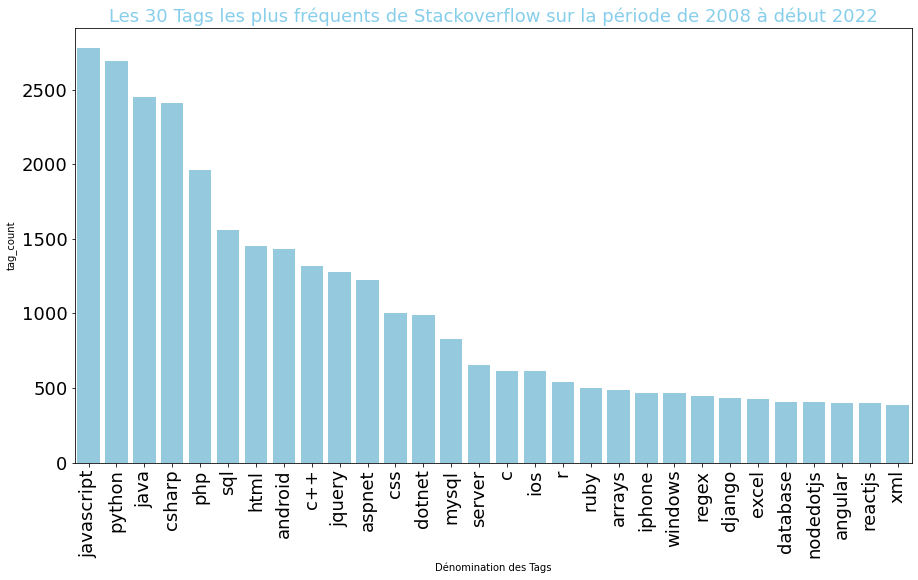

In [110]:
fig = plt.figure(figsize=(15, 8))
sns.barplot(
    data=tags_count.iloc[0:30, :],
    x=tags_count.iloc[0:30, :].index,
    y="tag_count",
    color="skyblue",
)
plt.xticks(rotation=90)
plt.xlabel("Dénomination des Tags")
# plt.ylabel('Nombre de Tags')
plt.title(
    "Les 30 Tags les plus fréquents de Stackoverflow sur la période de 2008 à début 2022",
    fontsize=18,
    color="skyblue",
)
plt.show()

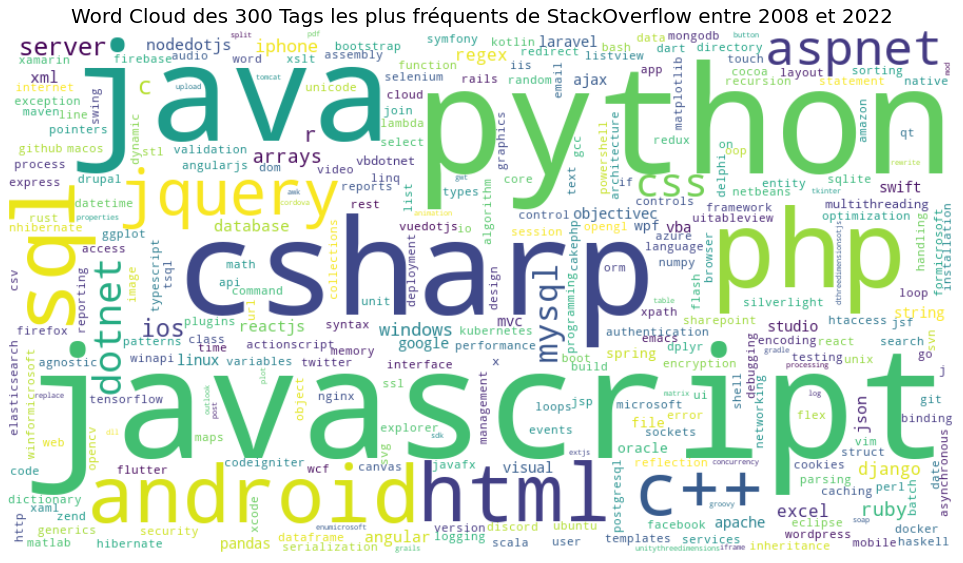

In [111]:
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=300,
    relative_scaling=1,
    normalize_plurals=False,
).generate_from_frequencies(tags_count.to_dict()["tag_count"])

ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 Tags les plus fréquents de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

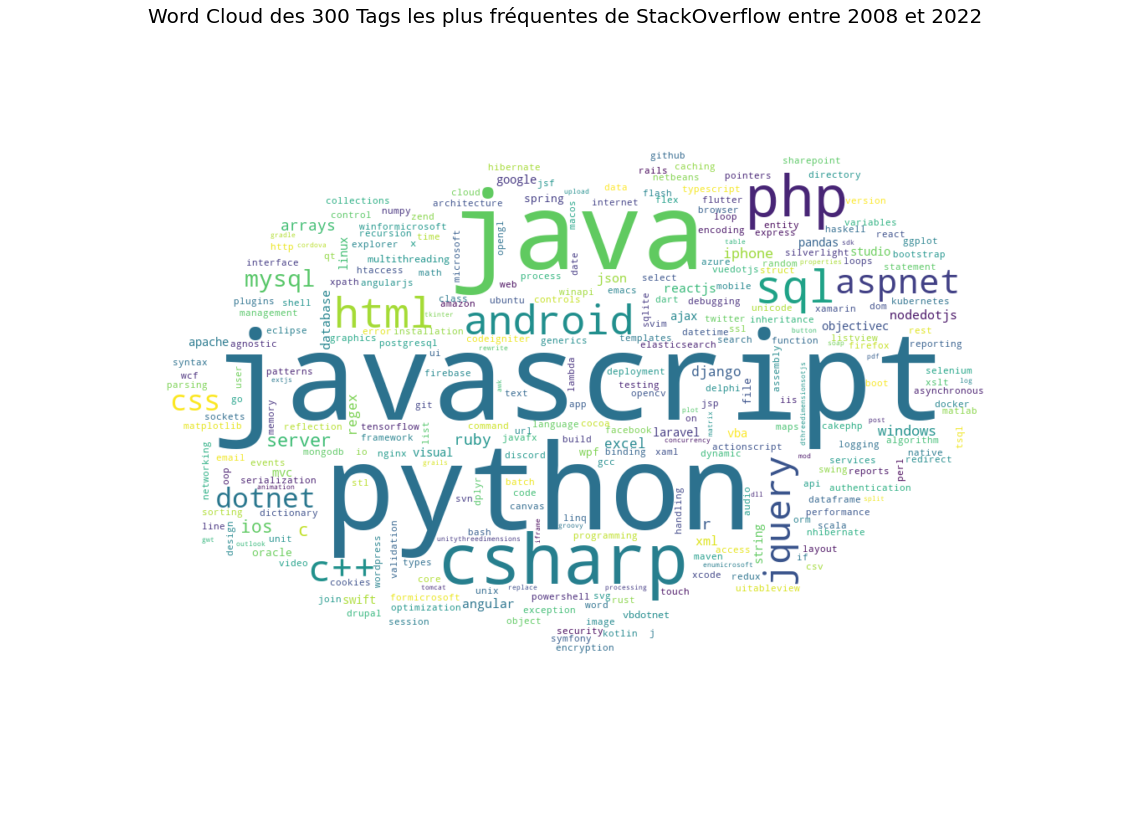

In [112]:
mask = np.array(Image.open("cloud.png"))
mask[mask == 1] = 255


fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=300,
    relative_scaling=1,
    mask=mask,
    normalize_plurals=False,
).generate_from_frequencies(tags_count.to_dict()["tag_count"])

ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 Tags les plus fréquentes de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

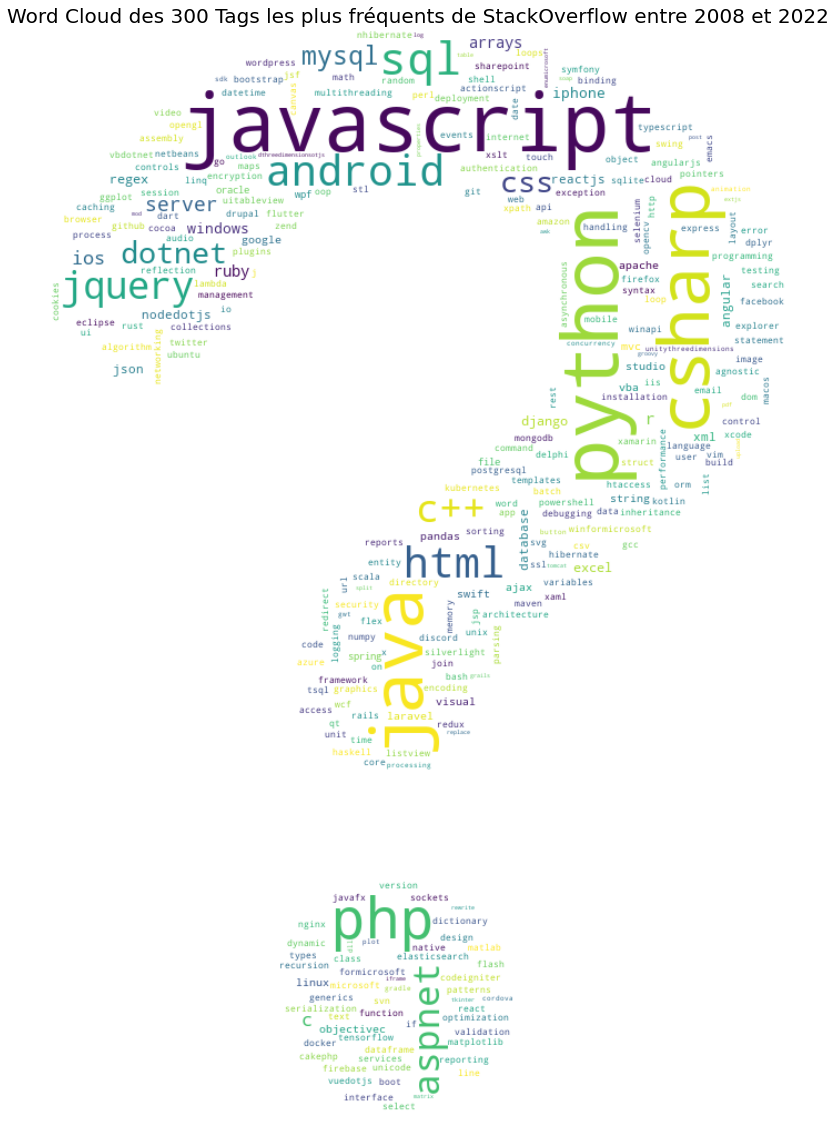

In [113]:
mask = np.array(Image.open("question-mark.png"))
mask[mask == 1] = 255


fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=300,
    relative_scaling=1,
    mask=mask,
    normalize_plurals=False,
).generate_from_frequencies(tags_count.to_dict()["tag_count"])

ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 Tags les plus fréquents de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

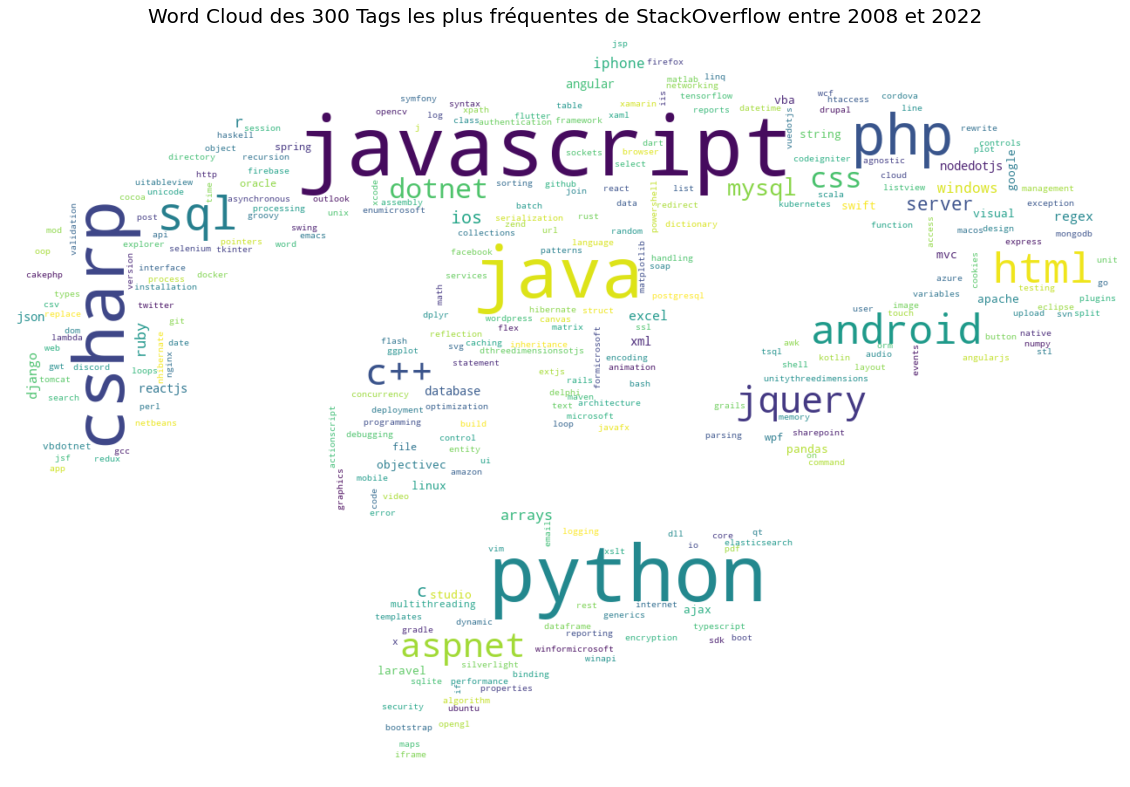

In [114]:
mask = np.array(Image.open("question-mark-exclamation.png"))
mask[mask == 1] = 255


fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=300,
    relative_scaling=1,
    mask=mask,
    normalize_plurals=False,
).generate_from_frequencies(tags_count.to_dict()["tag_count"])

ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 Tags les plus fréquentes de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

#### Analyse de la variable `question`  :

In [115]:
list_question = list_word(df2, column="question_tok", separator=",")

In [116]:
print("La variable question compte", len(list_question), "mots.")

La variable question compte 4371425 mots.


#### Nettoyage des Stop Words :

#### Détermination de la langues des des observations de la variable `question`:

In [117]:
df2["language"] = df2.question.apply(defin_lang)

In [118]:
pd.DataFrame(df2.language.value_counts())

language
en     29276
fr         8
ca         7
it         6
es         4
nl         3
da         2
sv         2
pt         1
bn         1
no         1
de         1
ro         1
pl         1
hr         1

In [119]:
df4 = df2[df2["language"] == "en"]

In [120]:
df4.shape

(29276, 21)

#### Vérification de la période d'étallement de notre base de données suite aux dernières suppressions d'individus :

In [121]:
time_delta = int(
    (df4["CreationDate"].max() - df4["CreationDate"].min()) / np.timedelta64(1, "Y")
)
print(
    "La période dont nous disposons est de",
    time_delta,
    "ans, elle commence le",
    df4["CreationDate"].min(),
    "et se termine le",
    df4["CreationDate"].max(),
    ".",
)

La période dont nous disposons est de 13 ans, elle commence le 2008-07-31 23:40:59 et se termine le 2022-01-16 03:52:02 .


#### Maintenant que nous avons un corpus de texte entièrment en langue anglaise, nous pouvons procéder à l'élimination des Stopwords :

In [122]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [123]:
stop_words = set(stopwords.words("english"))

In [124]:
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','+','-','*','/','k','b','d','e','g','h','j','l','m','n','o','p','q','w','u','v','z','x','f','px','ps','rd','df','td','li','ad','br','cs','dd','de','eg','en','ex','ie','nd','ok','id']) # remove it if you this characters 

In [125]:
df4["question_clean"] = df4["question_tok"].apply(supp_stopwords)

C:\Users\laure\AppData\Local\Temp/ipykernel_29764/1628202896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["question_clean"] = df4["question_tok"].apply(supp_stopwords)


#### Visualisation des mots du corpus de la variable `question_clean`:

In [126]:
list_question = list_word(df4, column="question_clean", separator=",")

In [127]:
fdist = FreqDist()
for word in list_question:
    fdist[word] += 1

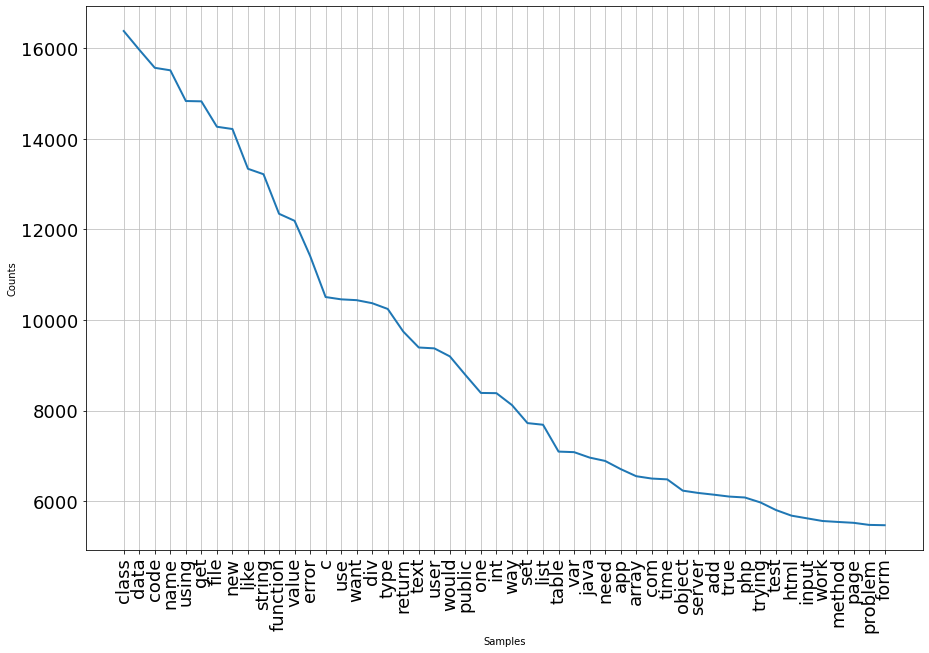

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [128]:
fig, ax = plt.subplots(figsize=(15, 10))
fdist.plot(50, cumulative=False)

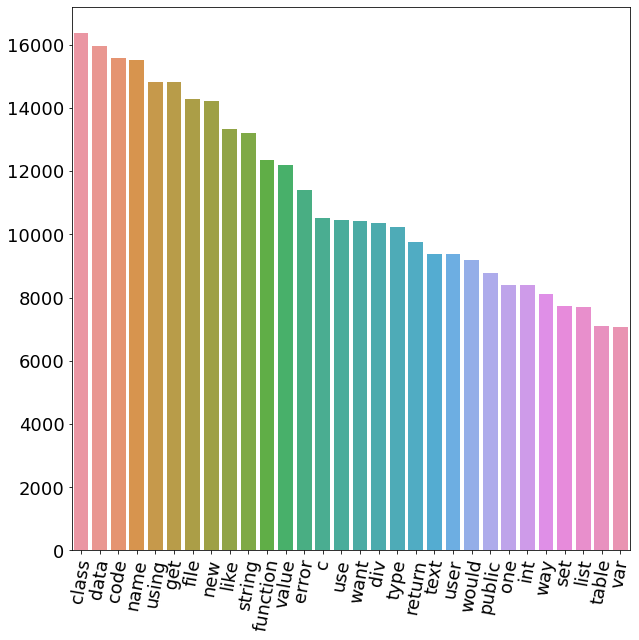

In [129]:
fdist_1 = fdist.most_common(30)

fdist_2 = pd.Series(dict(fdist_1))

fig, ax = plt.subplots(figsize=(10, 10))

all_plot = sns.barplot(x=fdist_2.index, y=fdist_2.values, ax=ax)
plt.xticks(rotation=80);

In [130]:
text = (" ").join(list_question)

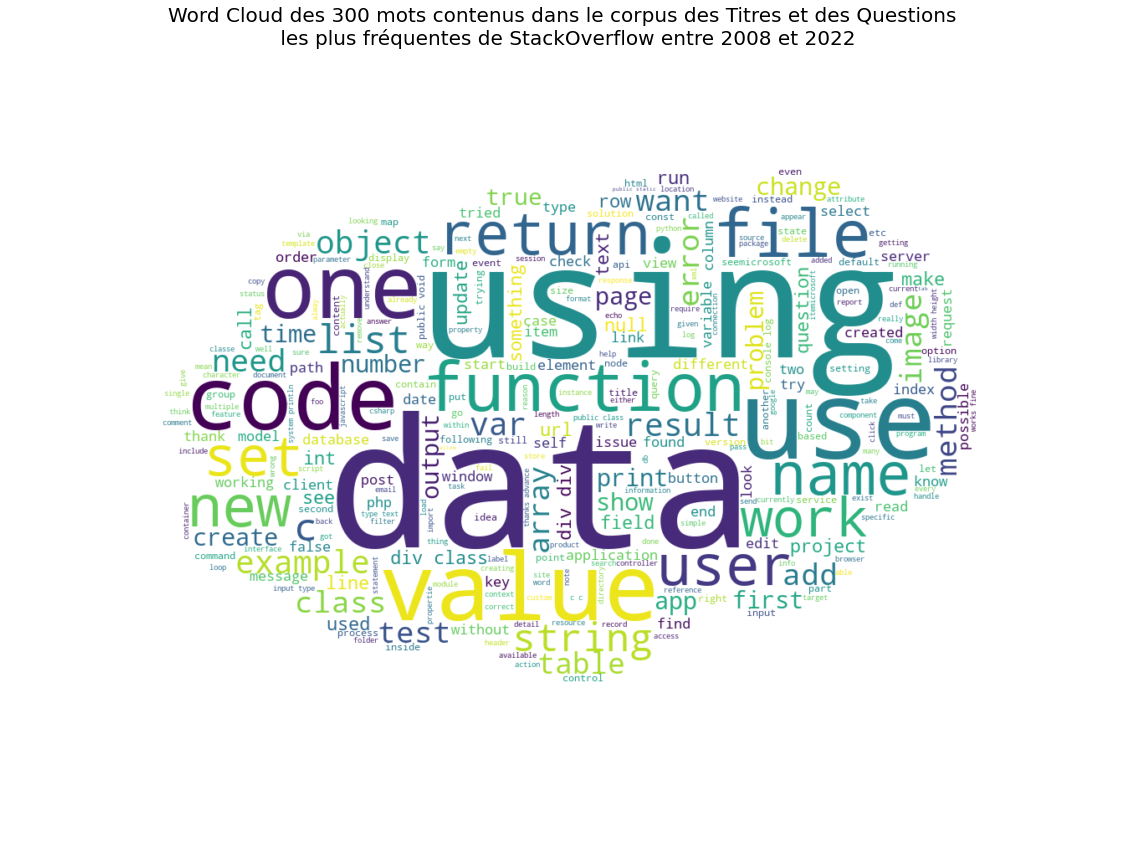

In [131]:
mask = np.array(Image.open("cloud.png"))
mask[mask == 1] = 255

fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

wordcloud = WordCloud(
    width=900, height=500, background_color="white", max_words=300, mask=mask
).generate(text)
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 mots contenus dans le corpus des Titres et des Questions \n les plus fréquentes de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

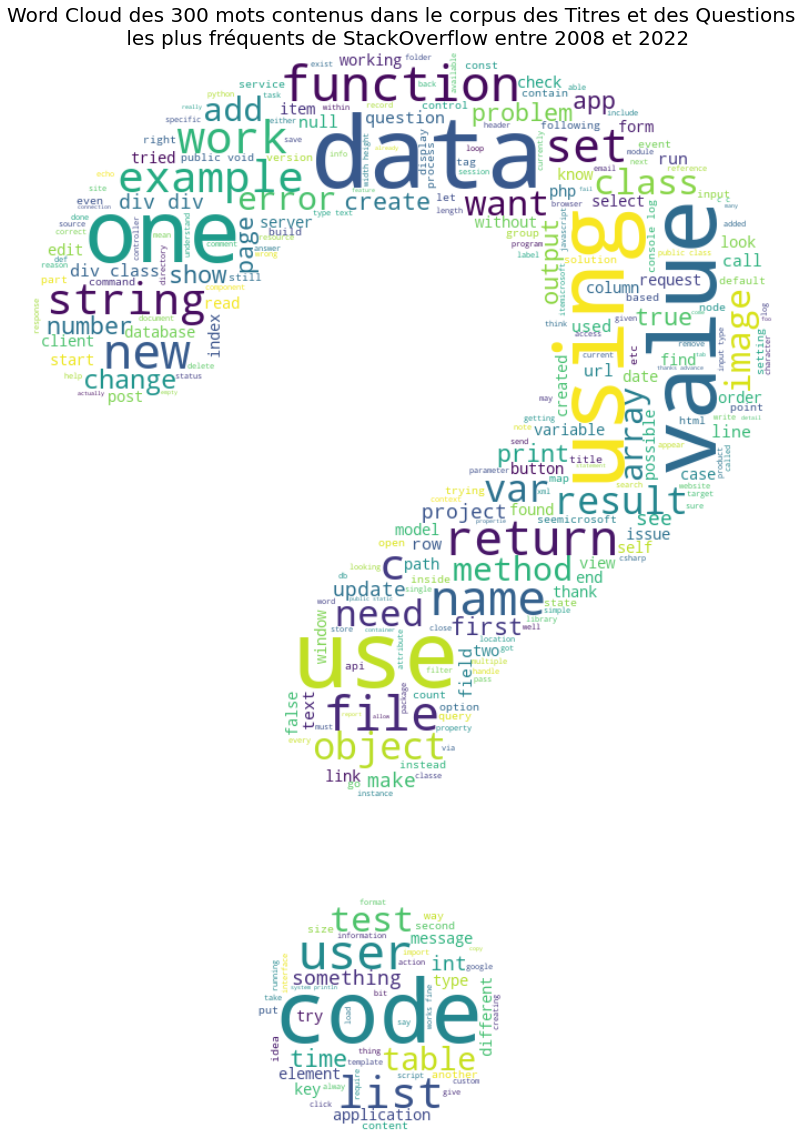

In [132]:
mask = np.array(Image.open("question-mark.png"))
mask[mask == 1] = 255

fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

wordcloud = WordCloud(
    width=900, height=500, background_color="white", max_words=300, mask=mask
).generate(text)
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 mots contenus dans le corpus des Titres et des Questions \n les plus fréquents de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

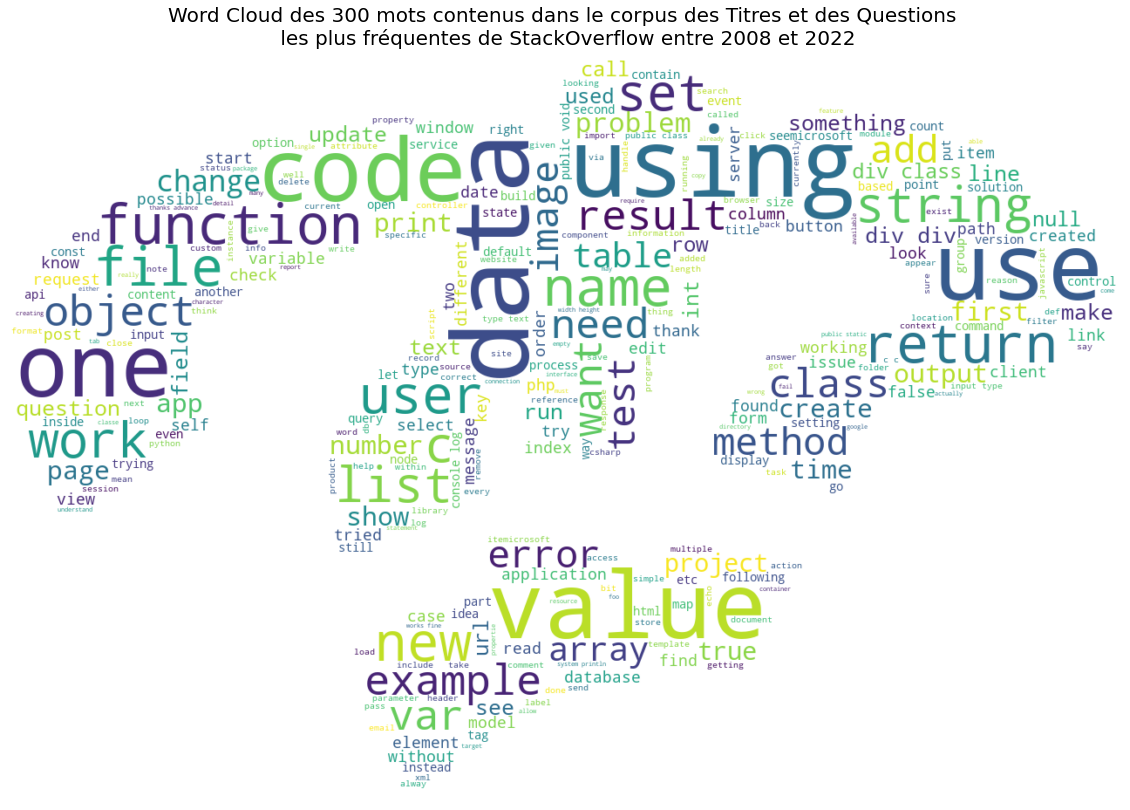

In [397]:
mask = np.array(Image.open("question-mark-exclamation.png"))
mask[mask == 1] = 255

fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)

wordcloud = WordCloud(
    width=900, height=500, background_color="white", max_words=300, mask=mask
).generate(text)
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.title(
    "Word Cloud des 300 mots contenus dans le corpus des Titres et des Questions \n les plus fréquentes de StackOverflow entre 2008 et 2022",
    fontsize=20,
)
plt.show()

#### Sélection des indiviuds qui présente des tags qui font partie des plus fréquents :

In [398]:
list_tag = list_word(df4, column="tag_tok", separator=",")

In [399]:
fdist = FreqDist()
for word in list_tag:
    fdist[word] += 1

In [400]:
len(fdist.keys())

7240

In [401]:
newDict = {key: value for (key, value) in fdist.items() if value > 100 }

In [402]:
display(fdist)

FreqDist({'javascript': 2774, 'python': 2689, 'java': 2446, 'csharp': 2409, 'php': 1960, 'sql': 1558, 'html': 1446, 'android': 1428, 'c++': 1319, 'jquery': 1273, ...})

In [403]:
len(newDict)

124

In [404]:
#On liste les tags que nous souhaitons supprimer
list_tags = list(newDict.keys())
print (list_tags)

['csharp', 'dotnet', 'datetime', 'linq', 'file', 'java', 'php', 'oop', 'c', 'linux', 'security', 'c++', 'python', 'arrays', 'html', 'css', 'string', 'postgresql', 'aspnet', 'regex', 'parsing', 'mysql', 'database', 'performance', 'apache', 'exception', 'sql', 'server', 'windows', 'xml', 'javascript', 'data', 'svn', 'flash', 'http', 'perl', 'actionscript', 'ruby', 'vbdotnet', 'macos', 'testing', 'design', 'user', 'interface', 'formicrosoft', 'date', 'swing', 'csv', 'objectivec', 'microsoft', 'access', 'visual', 'studio', 'multithreading', 'oracle', 'memory', 'algorithm', 'iis', 'silverlight', 'winformicrosoft', 'wpf', 'powershell', 'delphi', 'ajax', 'image', 'web', 'mvc', 'sqlite', 'services', 'validation', 'json', 'xcode', 'excel', 'shell', 'ios', 'class', 'jquery', 'wcf', 'django', 'templates', 'iphone', 'git', 'eclipse', 'api', 'spring', 'generics', 'cocoa', 'framework', 'bash', 'list', 'google', 'function', 'vba', 'scala', 'hibernate', 'wordpress', 'on', 'rails', 'android', 'twitter'

In [405]:
#On créé une nouvelle variable contenant les tags qui ont une réccurence supérieure à 100
df4['tags_pop'] = [' '.join([y for y in x.split() if y in list_tags]) for x in df4['tag']]

C:\Users\laure\AppData\Local\Temp/ipykernel_11064/2353926628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['tags_pop'] = [' '.join([y for y in x.split() if y in list_tags]) for x in df4['tag']]


In [406]:
df4

Id        CreationDate  \
1             9 2008-07-31 23:40:59   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
6           126 2008-08-01 16:10:30   
8           263 2008-08-01 23:27:24   
...         ...                 ...   
48524  70724202 2022-01-15 18:24:04   
48526  70724561 2022-01-15 19:09:20   
48528  70725005 2022-01-15 20:05:04   
48530  70725976 2022-01-15 22:33:40   
48532  70727243 2022-01-16 03:52:02   

                                                                                                Title  \
1                                 How do I calculate someone's age based on a DateTime type birthday?   
3                         How do I get a distinct, ordered list of names from a DataTable using LINQ?   
4                              Microsoft Office 2007 file type, Mime types and identifying characters   
6                                How would you access Object properties from within an object method?   
8                                                                    GTK implementation of MessageBox   
...                                                                                               ...   
48524                                       Remove duplicates from an array of objects and update key   
48526  In a matrix for a given index, how do I check if any neighboring values are 2 smaller than it?   
48528                                                   Declaring stringstream crashes the app in C++   
48530                  How to make a reference to a concrete subtype in an abstract method definition   
48532                    How to initialize to an empty array if my 'students' parameter is not passed   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Body  \
1                                                                                                                                                                                                                                                                                                                                                                                                          

In [407]:
#On supprime les lignes sans tags
df4 = df4[df4['tags_pop']!='']

df4.shape

(26208, 23)

In [408]:
df4["tag_pop_norm"] = df4["tags_pop"].apply(code_norm)
df4["tag_pop_tok"] = df4["tag_pop_norm"].apply(tokenize_text)

C:\Users\laure\AppData\Local\Temp/ipykernel_11064/2859016298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["tag_pop_norm"] = df4["tags_pop"].apply(code_norm)
C:\Users\laure\AppData\Local\Temp/ipykernel_11064/2859016298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["tag_pop_tok"] = df4["tag_pop_norm"].apply(tokenize_text)


#### Lemmatisation des variables `question` et `tag` :

In [409]:
nlp = spacy.load('en_core_web_sm')
keep_postags = ['NOUN', 'ADJ', 'VERB', 'ADV', 'ADP']

In [410]:
pd.options.display.max_columns = None
df4

Id        CreationDate  \
1             9 2008-07-31 23:40:59   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
6           126 2008-08-01 16:10:30   
8           263 2008-08-01 23:27:24   
...         ...                 ...   
48524  70724202 2022-01-15 18:24:04   
48526  70724561 2022-01-15 19:09:20   
48528  70725005 2022-01-15 20:05:04   
48530  70725976 2022-01-15 22:33:40   
48532  70727243 2022-01-16 03:52:02   

                                                                                                Title  \
1                                 How do I calculate someone's age based on a DateTime type birthday?   
3                         How do I get a distinct, ordered list of names from a DataTable using LINQ?   
4                              Microsoft Office 2007 file type, Mime types and identifying characters   
6                                How would you access Object properties from within an object method?   
8                                                                    GTK implementation of MessageBox   
...                                                                                               ...   
48524                                       Remove duplicates from an array of objects and update key   
48526  In a matrix for a given index, how do I check if any neighboring values are 2 smaller than it?   
48528                                                   Declaring stringstream crashes the app in C++   
48530                  How to make a reference to a concrete subtype in an abstract method definition   
48532                    How to initialize to an empty array if my 'students' parameter is not passed   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Body  \
1                                                                                                                                                                                                                                                                                                                                                                                                          

In [411]:
df5 = df4.copy()
df5["question_norm"] = df5["question"].apply(code_norm)
#df5["question_lem"] = df5["question"].apply(word_pos_lemma)

In [412]:
df5["question_lemnorm"] = df5["question_norm"].apply(word_pos_lemma)

In [413]:
little_words = ['c', 'r', 'x', 'on', 'qt']

In [414]:
df6 = df5.copy()
df6["question_lemnorm_tri"] = df6["question_lemnorm"].apply(len_words)
df6["tag_lem"] = df5["tag_pop_tok"].apply(lemmatizeur)

#### Stemmisation des variables `question` et `tag` :

In [415]:
df7 = df6.copy()
#df7["question_lemtok"] = df7["question_lemnorm"].apply(tokenize_text)
df7["question_lemtokcl"] = df7["question_lemnorm_tri"].apply(supp_stopwords)
df7["question_stem"] = df7["question_lemtokcl"].apply(stemmizeur)

In [416]:
df8 = df7.copy()
df8["tag_stem"] = df8["tag_lem"].apply(stemmizeur)

In [417]:
pd.options.display.max_columns = None
df8

Id        CreationDate  \
1             9 2008-07-31 23:40:59   
3            59 2008-08-01 13:14:33   
4            61 2008-08-01 13:17:20   
6           126 2008-08-01 16:10:30   
8           263 2008-08-01 23:27:24   
...         ...                 ...   
48524  70724202 2022-01-15 18:24:04   
48526  70724561 2022-01-15 19:09:20   
48528  70725005 2022-01-15 20:05:04   
48530  70725976 2022-01-15 22:33:40   
48532  70727243 2022-01-16 03:52:02   

                                                                                                Title  \
1                                 How do I calculate someone's age based on a DateTime type birthday?   
3                         How do I get a distinct, ordered list of names from a DataTable using LINQ?   
4                              Microsoft Office 2007 file type, Mime types and identifying characters   
6                                How would you access Object properties from within an object method?   
8                                                                    GTK implementation of MessageBox   
...                                                                                               ...   
48524                                       Remove duplicates from an array of objects and update key   
48526  In a matrix for a given index, how do I check if any neighboring values are 2 smaller than it?   
48528                                                   Declaring stringstream crashes the app in C++   
48530                  How to make a reference to a concrete subtype in an abstract method definition   
48532                    How to initialize to an empty array if my 'students' parameter is not passed   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Body  \
1                                                                                                                                                                                                                                                                                                                                                                                                          

#### Vérifications des processus effectués sur la base de données avec 2 exemples :

In [418]:
pd.set_option("display.max_colwidth", None)
print('****Le titre de la question du premier exemple à vérifier est :', type(df8['Title'].iloc[0]), df8['Title'].iloc[0])
print('****Le corps de la question du premier exemple à vérifier est :', type(df8['Body'].iloc[0]), df8['Body'].iloc[0])
print('****Le titre et le corps de la question du premier exemple :', type(df8['question'].iloc[0]), df8['question'].iloc[0])
print('****Le titre et le corps de la question du premier exemple une fois mis aux normes est :', type(df8['question_norm'].iloc[0]),  df8['question_norm'].iloc[0])
print('****Le titre et le corps de la question du premier exemple une fois tokenizés est :', type(df8['question_tok'].iloc[0]), df8['question_tok'].iloc[0])
print('****Le titre et le corps de la question du premier exemple une fois les stopwords retirés est :', type(df8['question_clean'].iloc[0]), df8['question_clean'].iloc[0])
print('****Le titre et le corps de la question du premier exemple une fois mis aux normes est :', type(df8['question_lemnorm'].iloc[0]), df8['question_lemnorm'].iloc[0])
print('****Le titre et le corps de la question du premier exemple une fois débarassé des stoppwords est :', type(df8['question_lemtokcl'].iloc[0]), df8['question_lemtokcl'].iloc[0])
print('****Le titre et le corps de la question du premier exemple une fois stemmizés est :', type(df8['question_stem'].iloc[0]), df8['question_stem'].iloc[0])
print('****Les tags de la question du premier exemple à vérifier sont :', df8['Tags'].iloc[0])
print('****Les tags de la question du premier exemple une fois nettoyés sont :', df8['tag'].iloc[0])
print('****Les tags de la question du premier exemple une fois mis aux normes sont :', df8['tag_norm'].iloc[0])
print('****Les tags de la question du premier exemple une fois tokenizés sont :', df8['tag_pop_tok'].iloc[0])
print('****Les tags de la question du premier exemple une fois lemmatizés sont :', df8['tag_lem'].iloc[0])
print('****Les tags de la question du premier exemple une fois stemmizés sont :', df8['tag_stem'].iloc[0])

****Le titre de la question du premier exemple à vérifier est : <class 'str'> How do I calculate someone's age based on a DateTime type birthday?
****Le corps de la question du premier exemple à vérifier est : <class 'str'> <p>Given a <code>DateTime</code> representing a person's birthday, how do I calculate their age in years?</p>

****Le titre et le corps de la question du premier exemple : <class 'str'> how do i calculate someone's age based on a datetime type birthday? given a  datetime  representing a person's birthday, how do i calculate their age in years? 

****Le titre et le corps de la question du premier exemple une fois mis aux normes est : <class 'str'> how do i calculate someone s age based on a datetime type birthday  given a  datetime  representing a person s birthday  how do i calculate their age in years  
****Le titre et le corps de la question du premier exemple une fois tokenizés est : <class 'list'> ['how', 'do', 'i', 'calculate', 'someone', 's', 'age', 'based', '

In [419]:
pd.set_option("display.max_colwidth", None)
print('****Le titre de la question du second exemple à vérifier est :', df8['Title'].iloc[14592])
print('****Le corps de la question du second exemple à vérifier est :', df8['Body'].iloc[14592])
print('****Le titre et le corps de la question du second exemple est :', df8['question'].iloc[14592])
print('****Le titre et le corps de la question du second exemple une fois mis aux normes est :', df8['question_norm'].iloc[14592])
print('****Le titre et le corps de la question du second exemple une fois tokenizés est :', df8['question_tok'].iloc[14592])
print('****Le titre et le corps de la question du second exemple une fois les stopwords retirés est :', df8['question_clean'].iloc[14592])
print('****Le titre et le corps de la question du second exemple une fois mis aux normes est :', df8['question_lemnorm'].iloc[14592])
print('****Le titre et le corps de la question du second exemple une fois les stopwords retirés est :', df8['question_lemtokcl'].iloc[14592])
print('****Le titre et le corps de la question du second exemple une fois stemmizés est :', df8['question_stem'].iloc[14592])
print('****Les tags de la question du second exemple à vérifier sont :', df8['Tags'].iloc[14592])
print('****Les tags de la question du second exemple une fois nettoyés sont :', df8['tag'].iloc[14592])
print('****Les tags de la question du second exemple une fois mis aux normes sont :', df8['tag_norm'].iloc[14592])
print('****Les tags de la question du second exemple une fois tokenizés sont :', df8['tag_pop_tok'].iloc[14592])
print('****Les tags de la question du second exemple une fois lemmatizés sont :', df8['tag_lem'].iloc[14592])
print('****Les tags de la question du second exemple une fois stemmizés sont :', df8['tag_stem'].iloc[14592])

****Le titre de la question du second exemple à vérifier est : bash sed a quoted string from file but only at the Nth line
****Le corps de la question du second exemple à vérifier est : <p>i know those two questions have been covered many time but i can't figure how to mix the two command in one:</p>

<p>get string between quote</p>

<pre><code>sed 's/[^"]*"\([^"]*\)".*/\1/' "$file"
</code></pre>

<p>get line 2 from file</p>

<pre><code>sed '2q;d' "$file"
</code></pre>

<p>many thanks for help.</p>

<p>EDIT:</p>

<p>input files are as follow:</p>

<pre><code>#!/bin/bash
# "/path/to/folder/with/file.ext"
some others lines with quoted string
</code></pre>

<p>output</p>

<pre><code>/path/to/folder/with/file.ext
</code></pre>

****Le titre et le corps de la question du second exemple est : bash sed a quoted string from file but only at the nth line i know those two questions have been covered many time but i can't figure how to mix the two command in one: 

 get string between quote 

  s

### Création de la base de données à exporter pour les test de modélisation de tagger automatique :

In [425]:
df9 = df8[
    [
        "Id",
        "CreationDate",
        "Tags",
        "tag",
        "tag_pop_norm",
        "tag_pop_tok",
        "question",
        "question_lemtokcl",
        "nb_w_title",
        "nb_w_body",
        "nb_w_quest",
        "nb_tag",
        "ViewCount",
        "AnswerCount",
        "Score"
    ]
]

In [426]:
pd.options.display.max_columns = None
df9.sample(10)

Id        CreationDate                                   Tags  \
37172  48633868 2018-02-06 00:53:48                       <python><pyside>   
9646    2061901 2010-01-14 03:05:08                      <bash><shell><sh>   
38893  60032510 2020-02-03 02:43:30           <python><validation><syntax>   
22449  22025547 2014-02-25 20:33:21   <javascript><unit-testing><ember.js>   
5848     288270 2008-11-13 20:58:52                   <sql-server><itunes>   
45445  70466321 2021-12-23 18:55:28                <xml><xpath><xpath-1.0>   
24411  22077066 2014-02-27 18:21:27                           <c++><break>   
30280  38080401 2016-06-28 15:29:21                           <r><dataset>   
338       21564 2008-08-22 01:24:34                     <unix><shell><awk>   
27425  22156947 2014-03-03 20:40:38  <ios><objective-c><uibutton><uitouch>   

                                          tag        tag_pop_norm  \
37172                         python  pyside               python   
9646                         bash  shell  sh           bash shell   
38893             python  validation  syntax    python validation   
22449   javascript  unit testing  emberdotjs   javascript testing   
5848                      sql server  itunes           sql server   
45445                  xml  xpath  xpath                      xml   
24411                             c++  break                  c++   
30280                             r  dataset                    r   
338                         unix  shell  awk                shell   
27425     ios  objectivec  uibutton  uitouch       ios objectivec   

                 tag_pop_tok  \
37172               [python]   
9646           [bash, shell]   
38893   [python, validation]   
22449  [javascript, testing]   
5848           [sql, server]   
45445                  [xml]   
24411                  [c++]   
30280                    [r]   
338                  [shell]   
27425      [ios, objectivec]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              question  \
37172                                                                                                                                                          

In [427]:
df9.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26208 entries, 1 to 48532
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Id                 26208 non-null  object        
 1   CreationDate       26208 non-null  datetime64[ns]
 2   Tags               26208 non-null  object        
 3   tag                26208 non-null  object        
 4   tag_pop_norm       26208 non-null  object        
 5   tag_pop_tok        26208 non-null  object        
 6   question           26208 non-null  object        
 7   question_lemtokcl  26208 non-null  object        
 8   nb_w_title         26208 non-null  int64         
 9   nb_w_body          26208 non-null  int64         
 10  nb_w_quest         26208 non-null  int64         
 11  nb_tag             26208 non-null  int64         
 12  ViewCount          26208 non-null  int64         
 13  AnswerCount        26208 non-null  int64         
 14  Score 

### Export de la base de données destinée aux modélisations :

In [428]:
df9.to_csv(
   "./dfP05modelisation.csv"
)

In [424]:
end_dr1 = time.process_time()
time_dr1 = end_dr1 - start_dr1
print('Run Time :', time_dr1)

Run Time : 1263.34375
